# Scaling law

In [1]:
import pickle , matplotlib.pyplot as plt, torch, numpy as np, argparse, time, os, scipy
from src.TorchDSP.pbc_new import NonlienarFeatures, FoPBC
from src.TorchDSP.dataloader import  get_signals
from src.TorchSimulation.receiver import  BER



class Model(object):
    def __init__(self, Nmodes, rho, L, index_type):
        self.Nmodes = Nmodes
        self.rho = rho
        self.L = L
        self.index_type = index_type
        self.features = NonlienarFeatures(Nmodes=self.Nmodes, rho=self.rho, L = self.L, index_type=self.index_type)
        self.C = torch.zeros(len(self.features.index), dtype=torch.complex64)

    def scatter(self, figsize=(10,10),dpi=400, s=3):
        x,y = zip(*self.features.index)
        values = np.log10(np.abs(self.C) + 1e-8)
        plt.figure(figsize=figsize, dpi=dpi)
        FoPBC(rho=self.rho, L=self.L, Nmodes=self.Nmodes, index_type=self.index_type).scatter_C(x,y,values, s=s)
        return 

    def scale(self, train_p, test_p):
        return 10**(test_p/10) / 10**(train_p/10)
    
    def fit(self, train_signal, train_truth, train_z, truncation=[0,-1], lamb_l2=0.1):
        s,e = truncation
        E = train_signal.val
        X = torch.squeeze(self.features(E, E, E))[s:e]
        Y = torch.squeeze(train_signal.val - train_truth.val)[s:e]
        A = (X.T.conj() @ X) / X.shape[0] + lamb_l2 * torch.eye(X.shape[1])               # A.eig: 4e5 ~ 1e8
        b = (X.T.conj()) @ Y /X.shape[0]
        self.C = torch.linalg.solve(A, b)
        print('Model fit complete!')
        return 
    
    def get_pbc(self, test_signal, train_p, test_p):
        PBC = (torch.squeeze(self.features(test_signal.val, test_signal.val, test_signal.val)) @ self.C ) * self.scale(train_p, test_p)
        return PBC


    def predict(self, test_signal, train_p, test_p, xi=1):
        return test_signal.val[0,:,0] - xi*self.get_pbc(test_signal, train_p, test_p)

    def test(self, test_signal, truth_signal, train_p, test_p, xi=1, BER_discard=10000):
        Yhat_test = self.predict(test_signal, train_p, test_p, xi=xi)
        return BER(Yhat_test[BER_discard: - BER_discard,None], truth_signal.val[0,BER_discard:-BER_discard])


BER_discard = 10000

# data

- 40G
  
|rho|L| train power | test power | train [s,e]  |  lamb_l2 | Q           | best Q           | 
|---------|---------|---------    |---------   |---------     |--------- |---------    |--------         |
|1|400| 1 | -2 | [2000:-2000] | 0 | 10.61 (xi=1)| 10.66 (xi=1.05)|
|1|400| 1 | -2 | [2000:-4000] | 0.05 | 10.62 (xi=1)| 10.65 (xi=1.05)|
|1|400| 1 | -2 | [10000:-10000] | 0.1 | 10.61 (xi=1)| 10.63 (xi=1.03)|
|1|400| 1 | -2 | [1000:-1000] | 0.1 | 10.61 (xi=1)| 10.65 (xi=1.05)|
|1|400| 1 | -2 | [2000:-4000] | 0.1 | 10.61 (xi=1)| 10.66 (xi=1.05)|
|1|400| 1 | -2 | [2000:-4000] | 0.2 | 10.58 (xi=1)| 10.65 (xi=1.07)|
|1|400| 1 | -1 | [2000:-2000] | 0 | 10.13 (xi=1)| 10.14 (xi=1.10)|
|1|400| 0 | -3 | [2000:-2000] | 0 | 10.46 (xi=1)| 10.48 (xi=0.95)|
|1|400| 0 | -3 | [2000:-2000] | 0.1 | 10.47 (xi=1)| 10.48 (xi=0.99)|
|1|400| -1 | -2 | [2000:-2000] | 0.1 | 10.60 (xi=1)| 10.62 (xi=0.94)|
|1|400| -2 | -2 | [2000:-2000] | 0.1 | 10.56 (xi=1)| 10.57 (xi=0.92)|
|1|400| -2 | -2 | [2000:-2000] | 0 | 10.52 (xi=1)| 10.58 (xi=0.95)|
|1|400| 0 | -2 | [10000:-10000] | 0 | 10.63 (xi=1)| 10.64 (xi=0.99)|
|1|400| 0 | -2 | [1000:-1000] | 0 | 10.63 (xi=1)| 10.64 (xi=0.92)|
|1|400| 0 | -2 | [1000:-1] | 0 | 10.63 (xi=1)| 10.64 (xi=0.92)|
|1|400| 0 | -2 | [0:-2000] | 0 | 10.60 (xi=1)| 10.64 (xi=0.92)|
|1|400| 0 | -2 | [0:-1] | 0 | 10.62 (xi=1)| 10.65 (xi=0.97)|
|1|400| 0 | -2 | [10000:-10000] | 0.01 | 10.64 (xi=1)| 10.64 (xi=0.95)|
|1|400| 0 | -2 | [2000:-4000] | 0.01 | 10.64 (xi=1)| 10.65 (xi=0.92)|
|1|400| 0 | -2 | [0:-1] | 0.1 | 10.64 (xi=1)| 10.65 (xi=0.99)|
|1|400| 0 | -2 | [1000:-1000] | 0.1 | 10.65 (xi=1)| 10.65 (xi=0.99)|
|1|400| 0 | -2 | [10000:-10000] | 0.1 | 10.65 (xi=1)| 10.65 (xi=1.02)|
|1|400| 0 | -2 | [2000:-4000] | 0.1 | 10.67 (xi=1)| 10.67 (xi=0.94)|
|1|400| 0 | -2 | [2000:-4000] | 0.05 | 10.64 (xi=1)| 10.67 (xi=1.04)|
|1|400| 0 | -2 | [10000:-10000] | 0.05 | 10.64 (xi=1)| 10.66 (xi=0.99)|
|1|400| 0 | -2 | [10000:-10000] | 0.2 | 10.65 (xi=1)| 10.67 (xi=1.03)|
|1|400| 0 | -2 | [10000:-10000] | 0.3 | 10.63 (xi=1)| 10.64 (xi=1.05)|
|1|200| 0 | -2 | [2000:-2000] | 0.1 | 10.54 (xi=1)| 10.55 (xi=1.06)|
|1|100| 0 | -2 | [2000:-2000] | 0.1 | 10.08 (xi=1)| 10.09 (xi=1.03)|
|2|100| 0 | -2 | [2000:-2000] | 0.1 | 10.39 (xi=1)| 10.40 (xi=0.97)|
|2|100| 0 | -2 | [2000:-2000] | 0 | 10.37 (xi=1)| 10.39 (xi=0.97)|

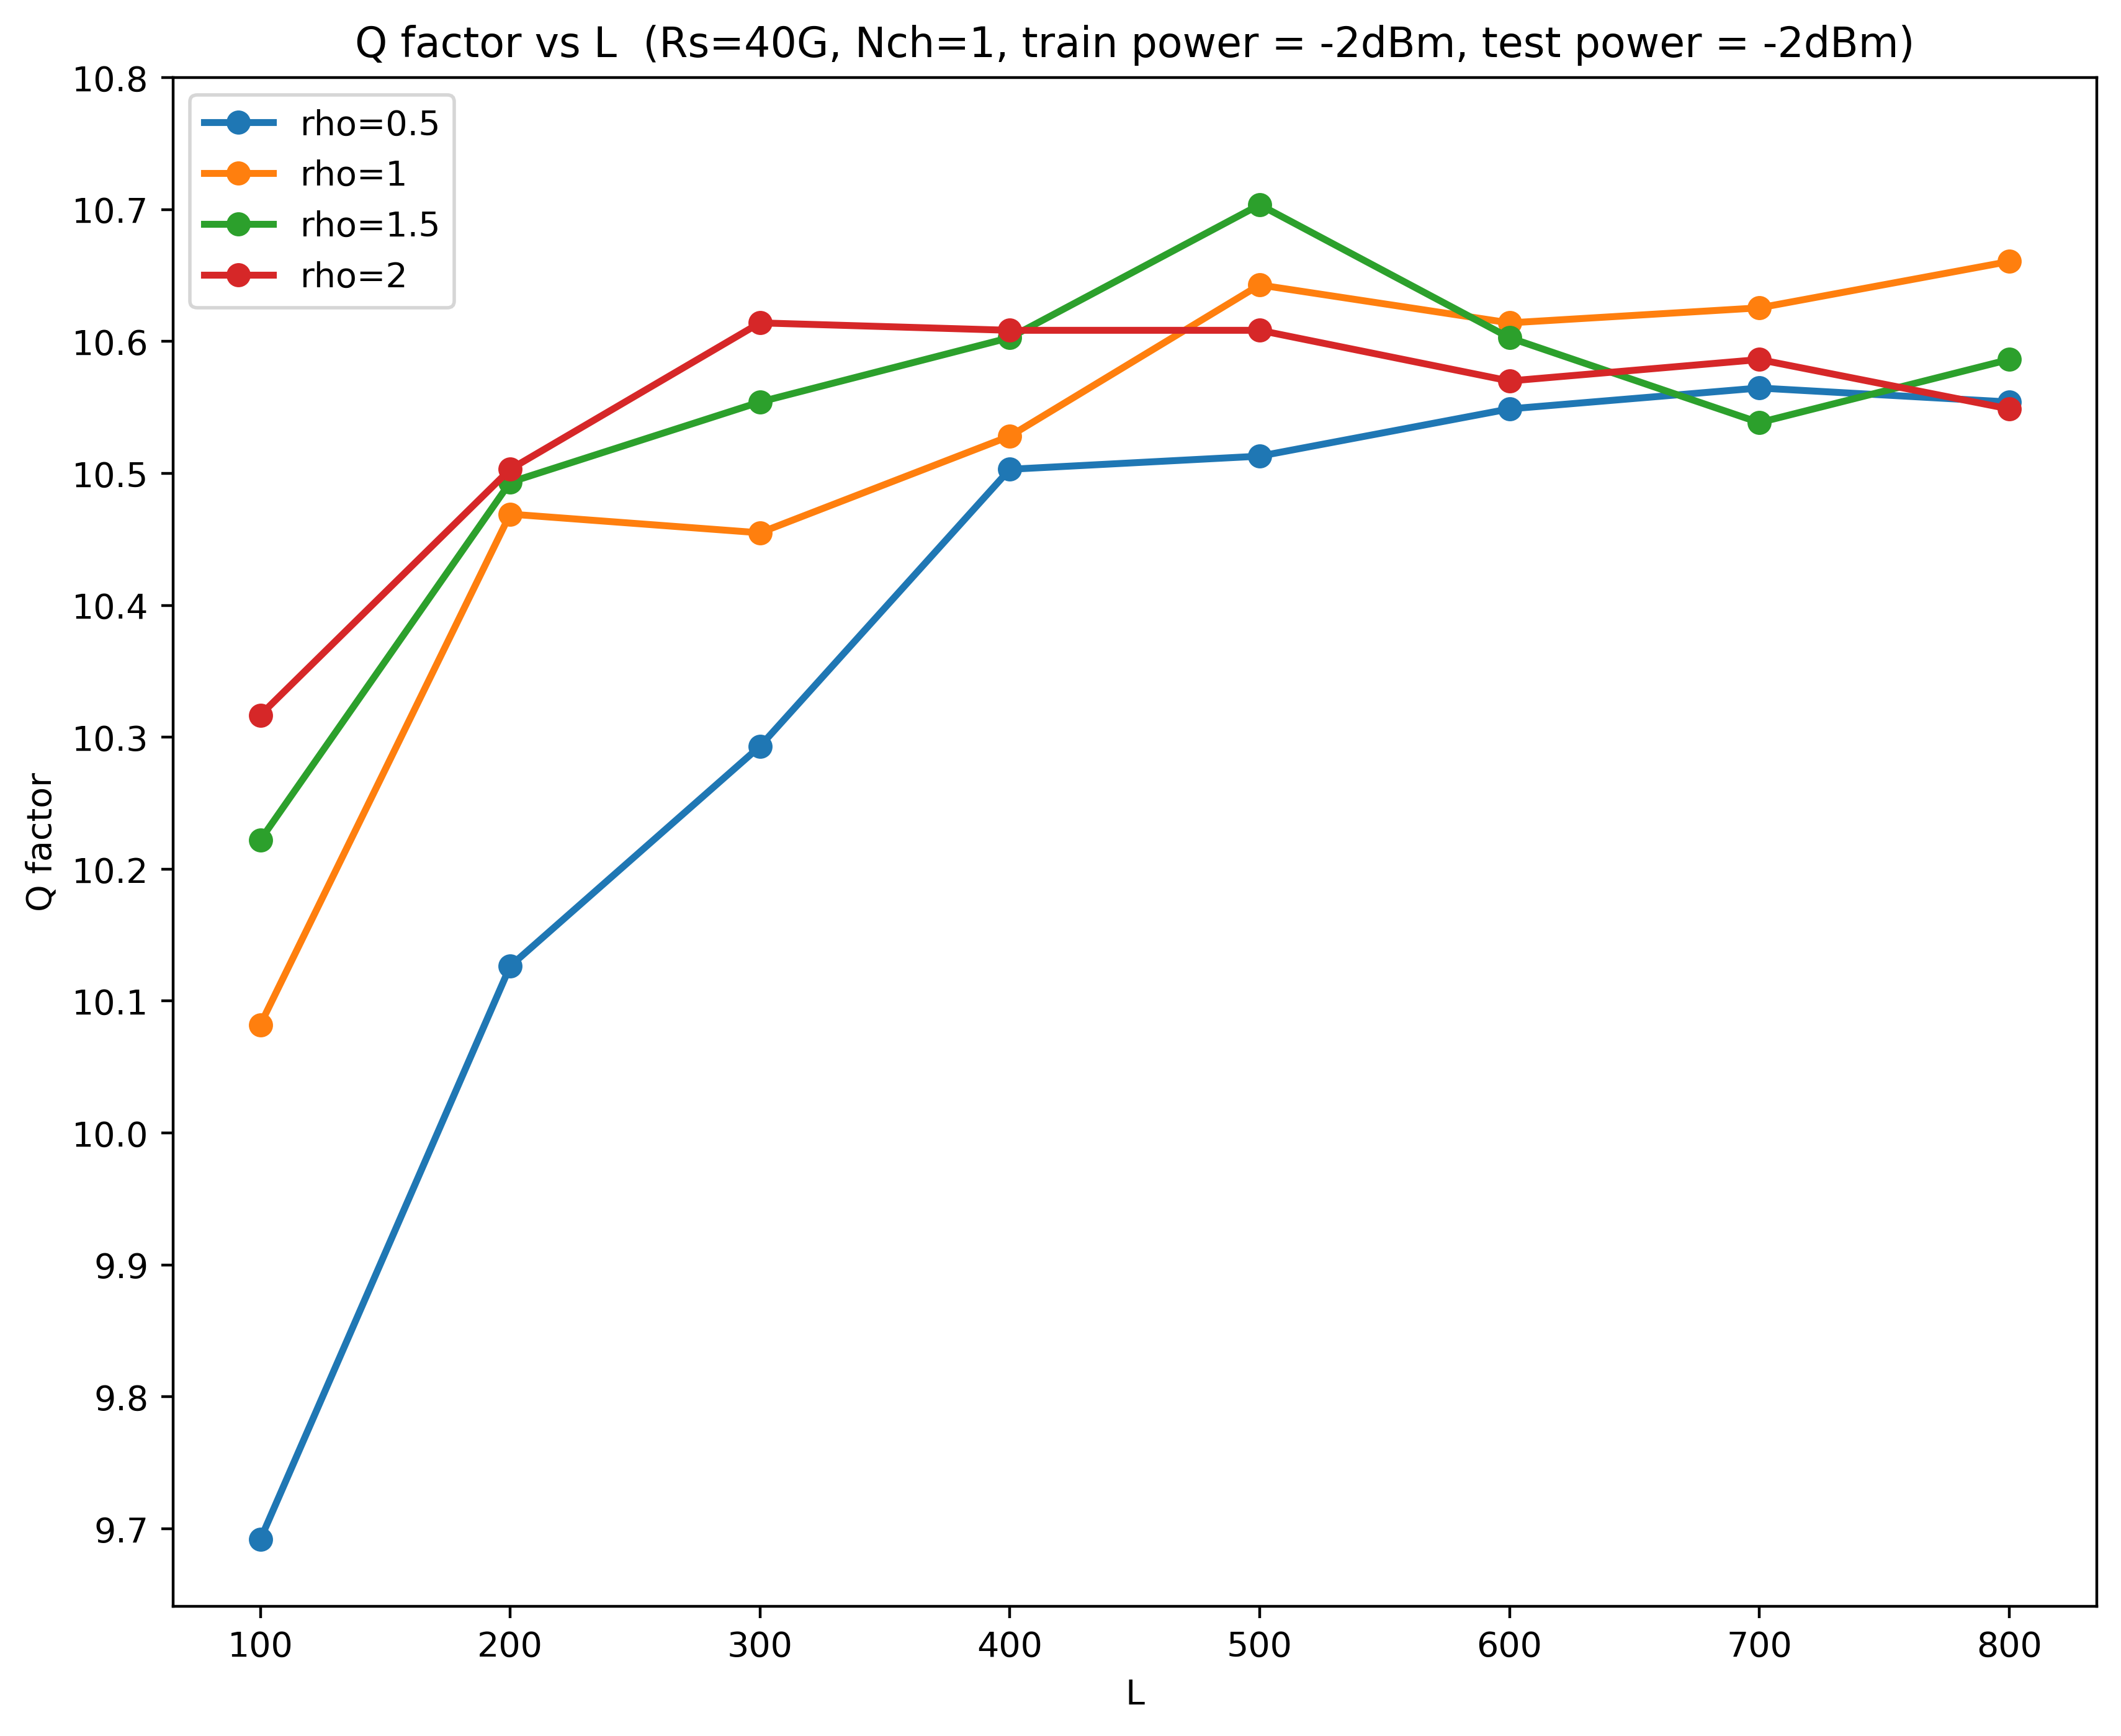

In [7]:
res = pickle.load(open('_outputs/res/res_rho_L_Tr-2_Te-2.pkl', 'rb'))

plt.figure(figsize=(10,8), dpi=400)
Ls = [100, 200, 300, 400, 500, 600, 700, 800]
plt.plot(Ls, [res[f'Q1 rho=0.5, L={L}'] for L in Ls], '-o',linewidth=2, label='rho=0.5')
plt.plot(Ls, [res[f'Q1 rho=1, L={L}'] for L in Ls],'-o',linewidth=2,label='rho=1')
plt.plot(Ls, [res[f'Q1 rho=1.5, L={L}'] for L in Ls],'-o',linewidth=2, label='rho=1.5')
plt.plot(Ls, [res[f'Q1 rho=2, L={L}'] for L in Ls],'-o',linewidth=2, label='rho=2')
plt.xlabel('L')
plt.ylabel('Q factor')
plt.title('Q factor vs L  (Rs=40G, Nch=1, train power = -2dBm, test power = -2dBm)')
plt.yticks(np.arange(9.7, 10.8, 0.1))
plt.legend()

In [11]:
res['Q1 rho=1.5, L=500']

10.703516

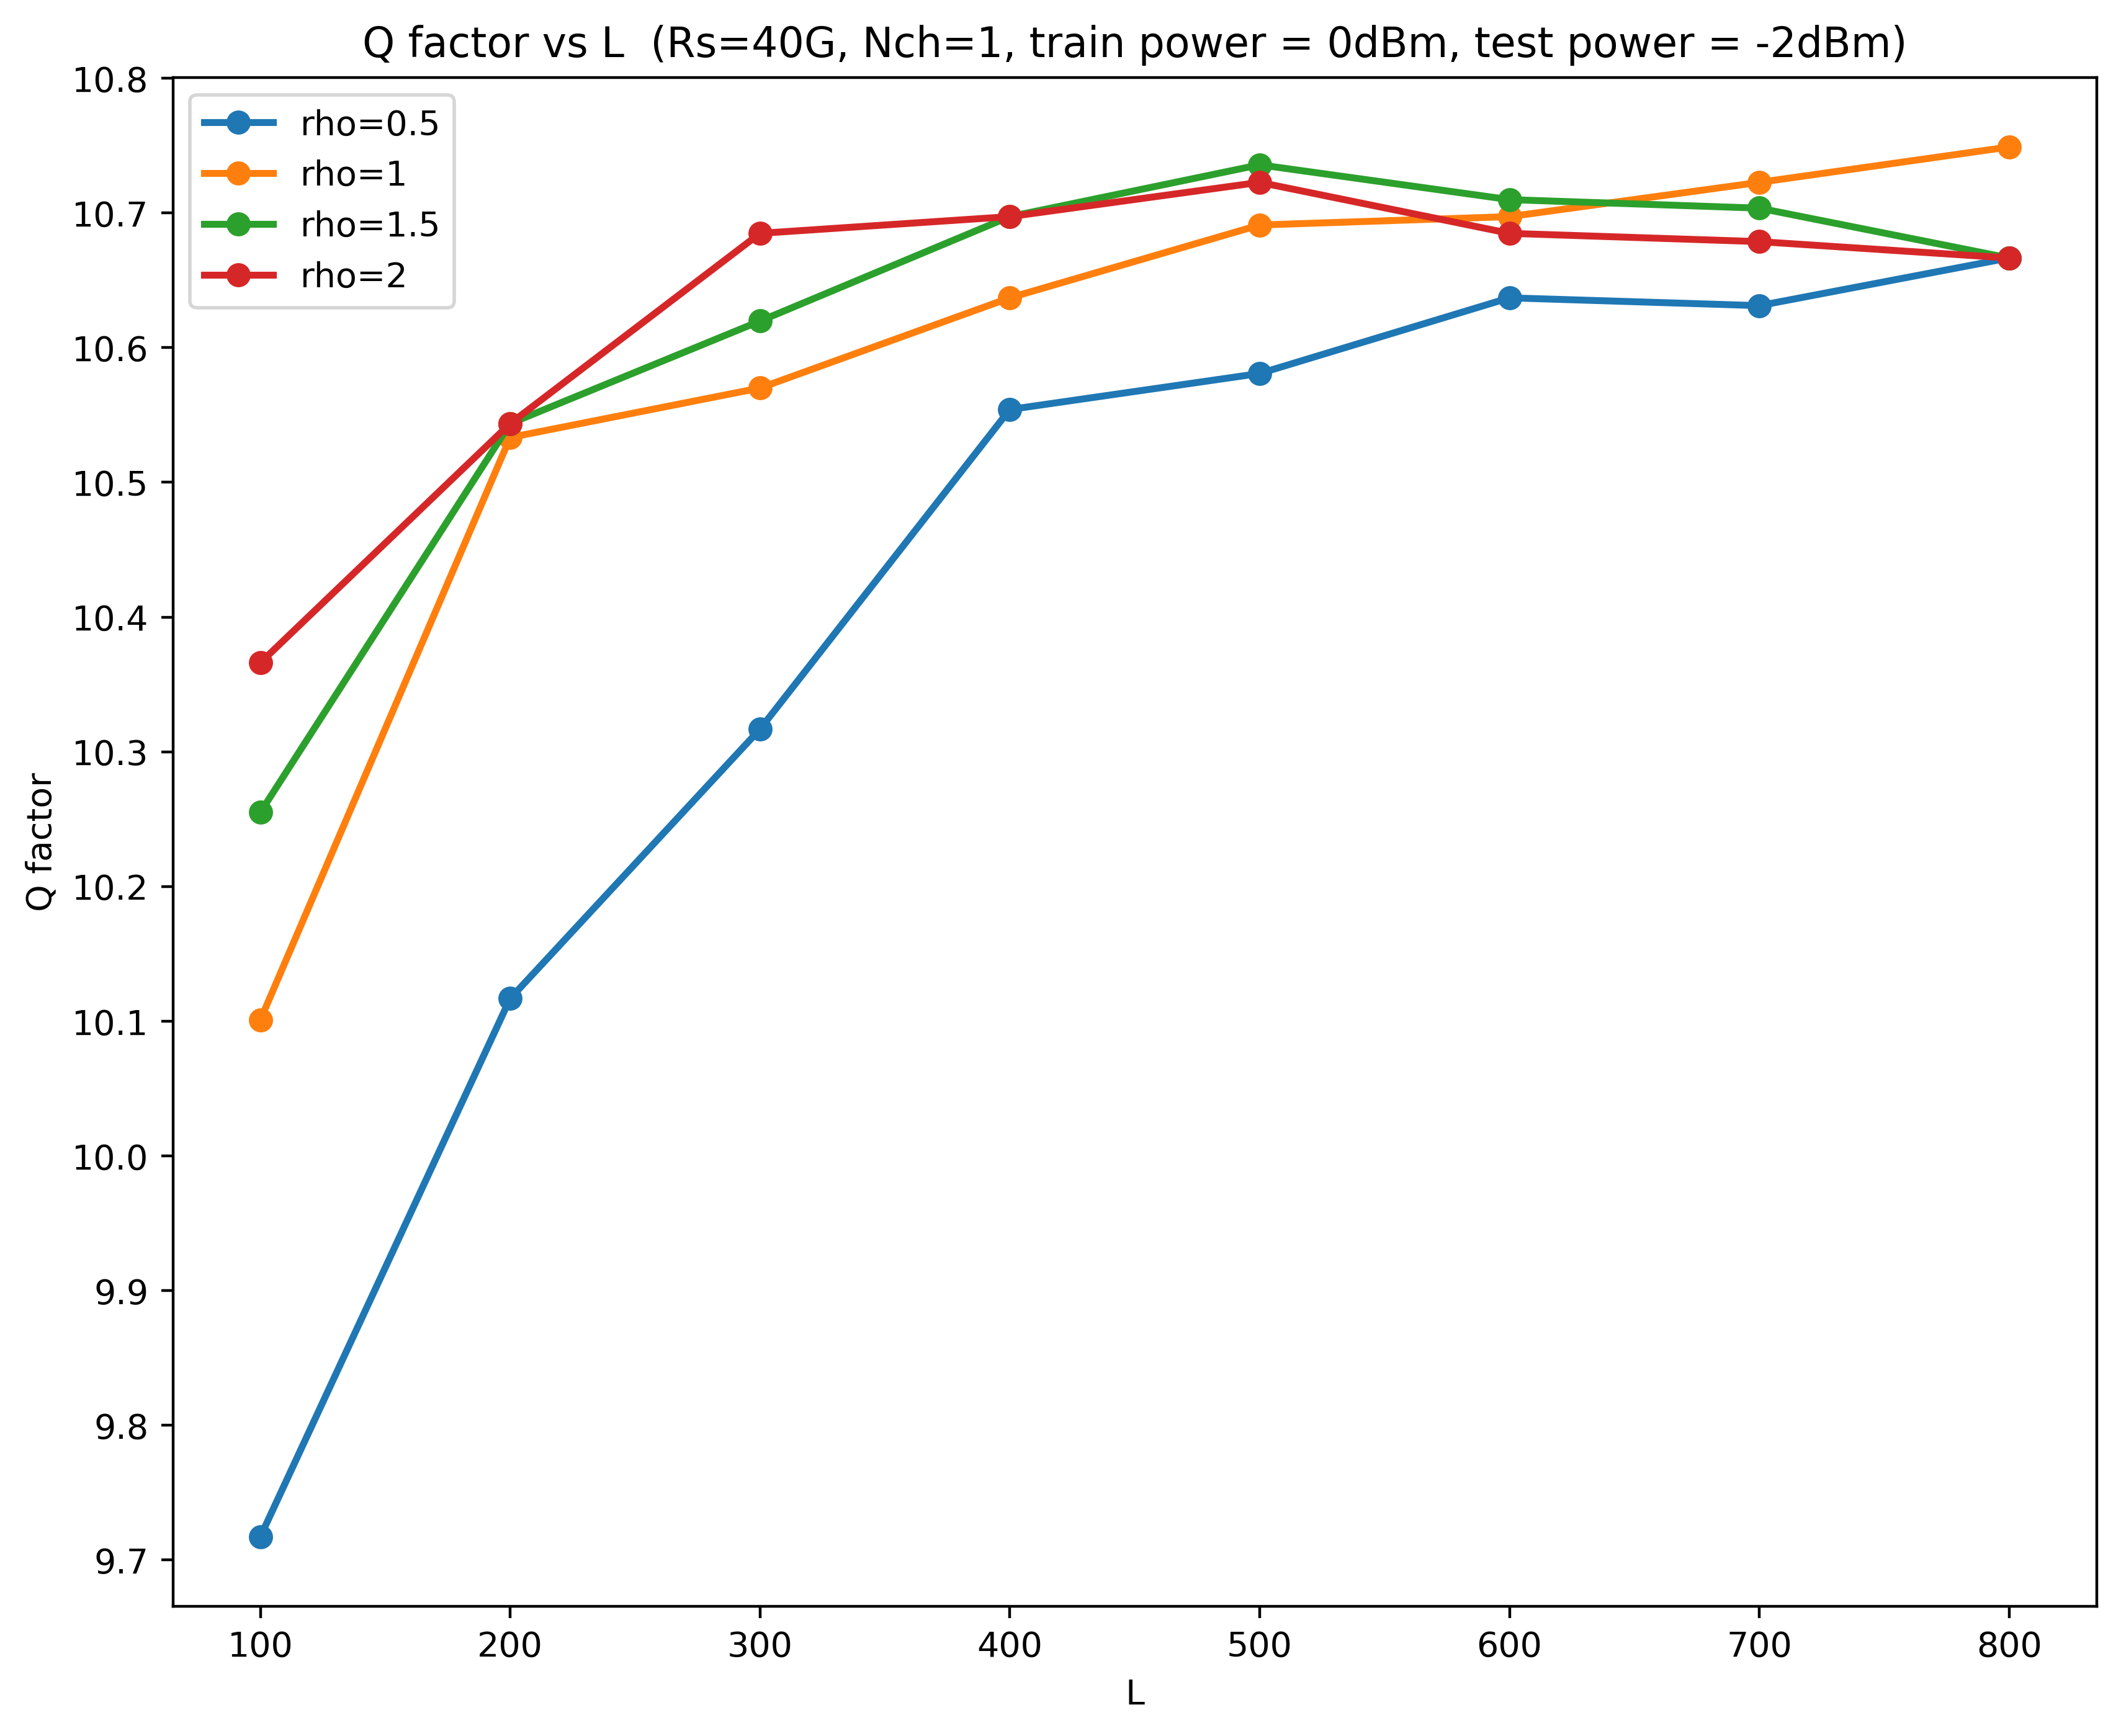

In [12]:
res = pickle.load(open('_outputs/res/res_rho_L_Tr0_Te-2.pkl', 'rb'))

plt.figure(figsize=(10,8), dpi=400)
Ls = [100, 200, 300, 400, 500, 600, 700, 800]
plt.plot(Ls, [res[f'Q1 rho=0.5, L={L}'] for L in Ls], '-o',linewidth=2, label='rho=0.5')
plt.plot(Ls, [res[f'Q1 rho=1, L={L}'] for L in Ls],'-o',linewidth=2,label='rho=1')
plt.plot(Ls, [res[f'Q1 rho=1.5, L={L}'] for L in Ls],'-o',linewidth=2, label='rho=1.5')
plt.plot(Ls, [res[f'Q1 rho=2, L={L}'] for L in Ls],'-o',linewidth=2, label='rho=2')
plt.xlabel('L')
plt.ylabel('Q factor')
plt.title('Q factor vs L  (Rs=40G, Nch=1, train power = 0dBm, test power = -2dBm)')
plt.yticks(np.arange(9.7, 10.8, 0.1))
plt.legend()

Text(0.5, 1.0, 'Q factor vs Data size  (Rs=40G, Nch=1, train power = -2dBm, test power = -2dBm)')

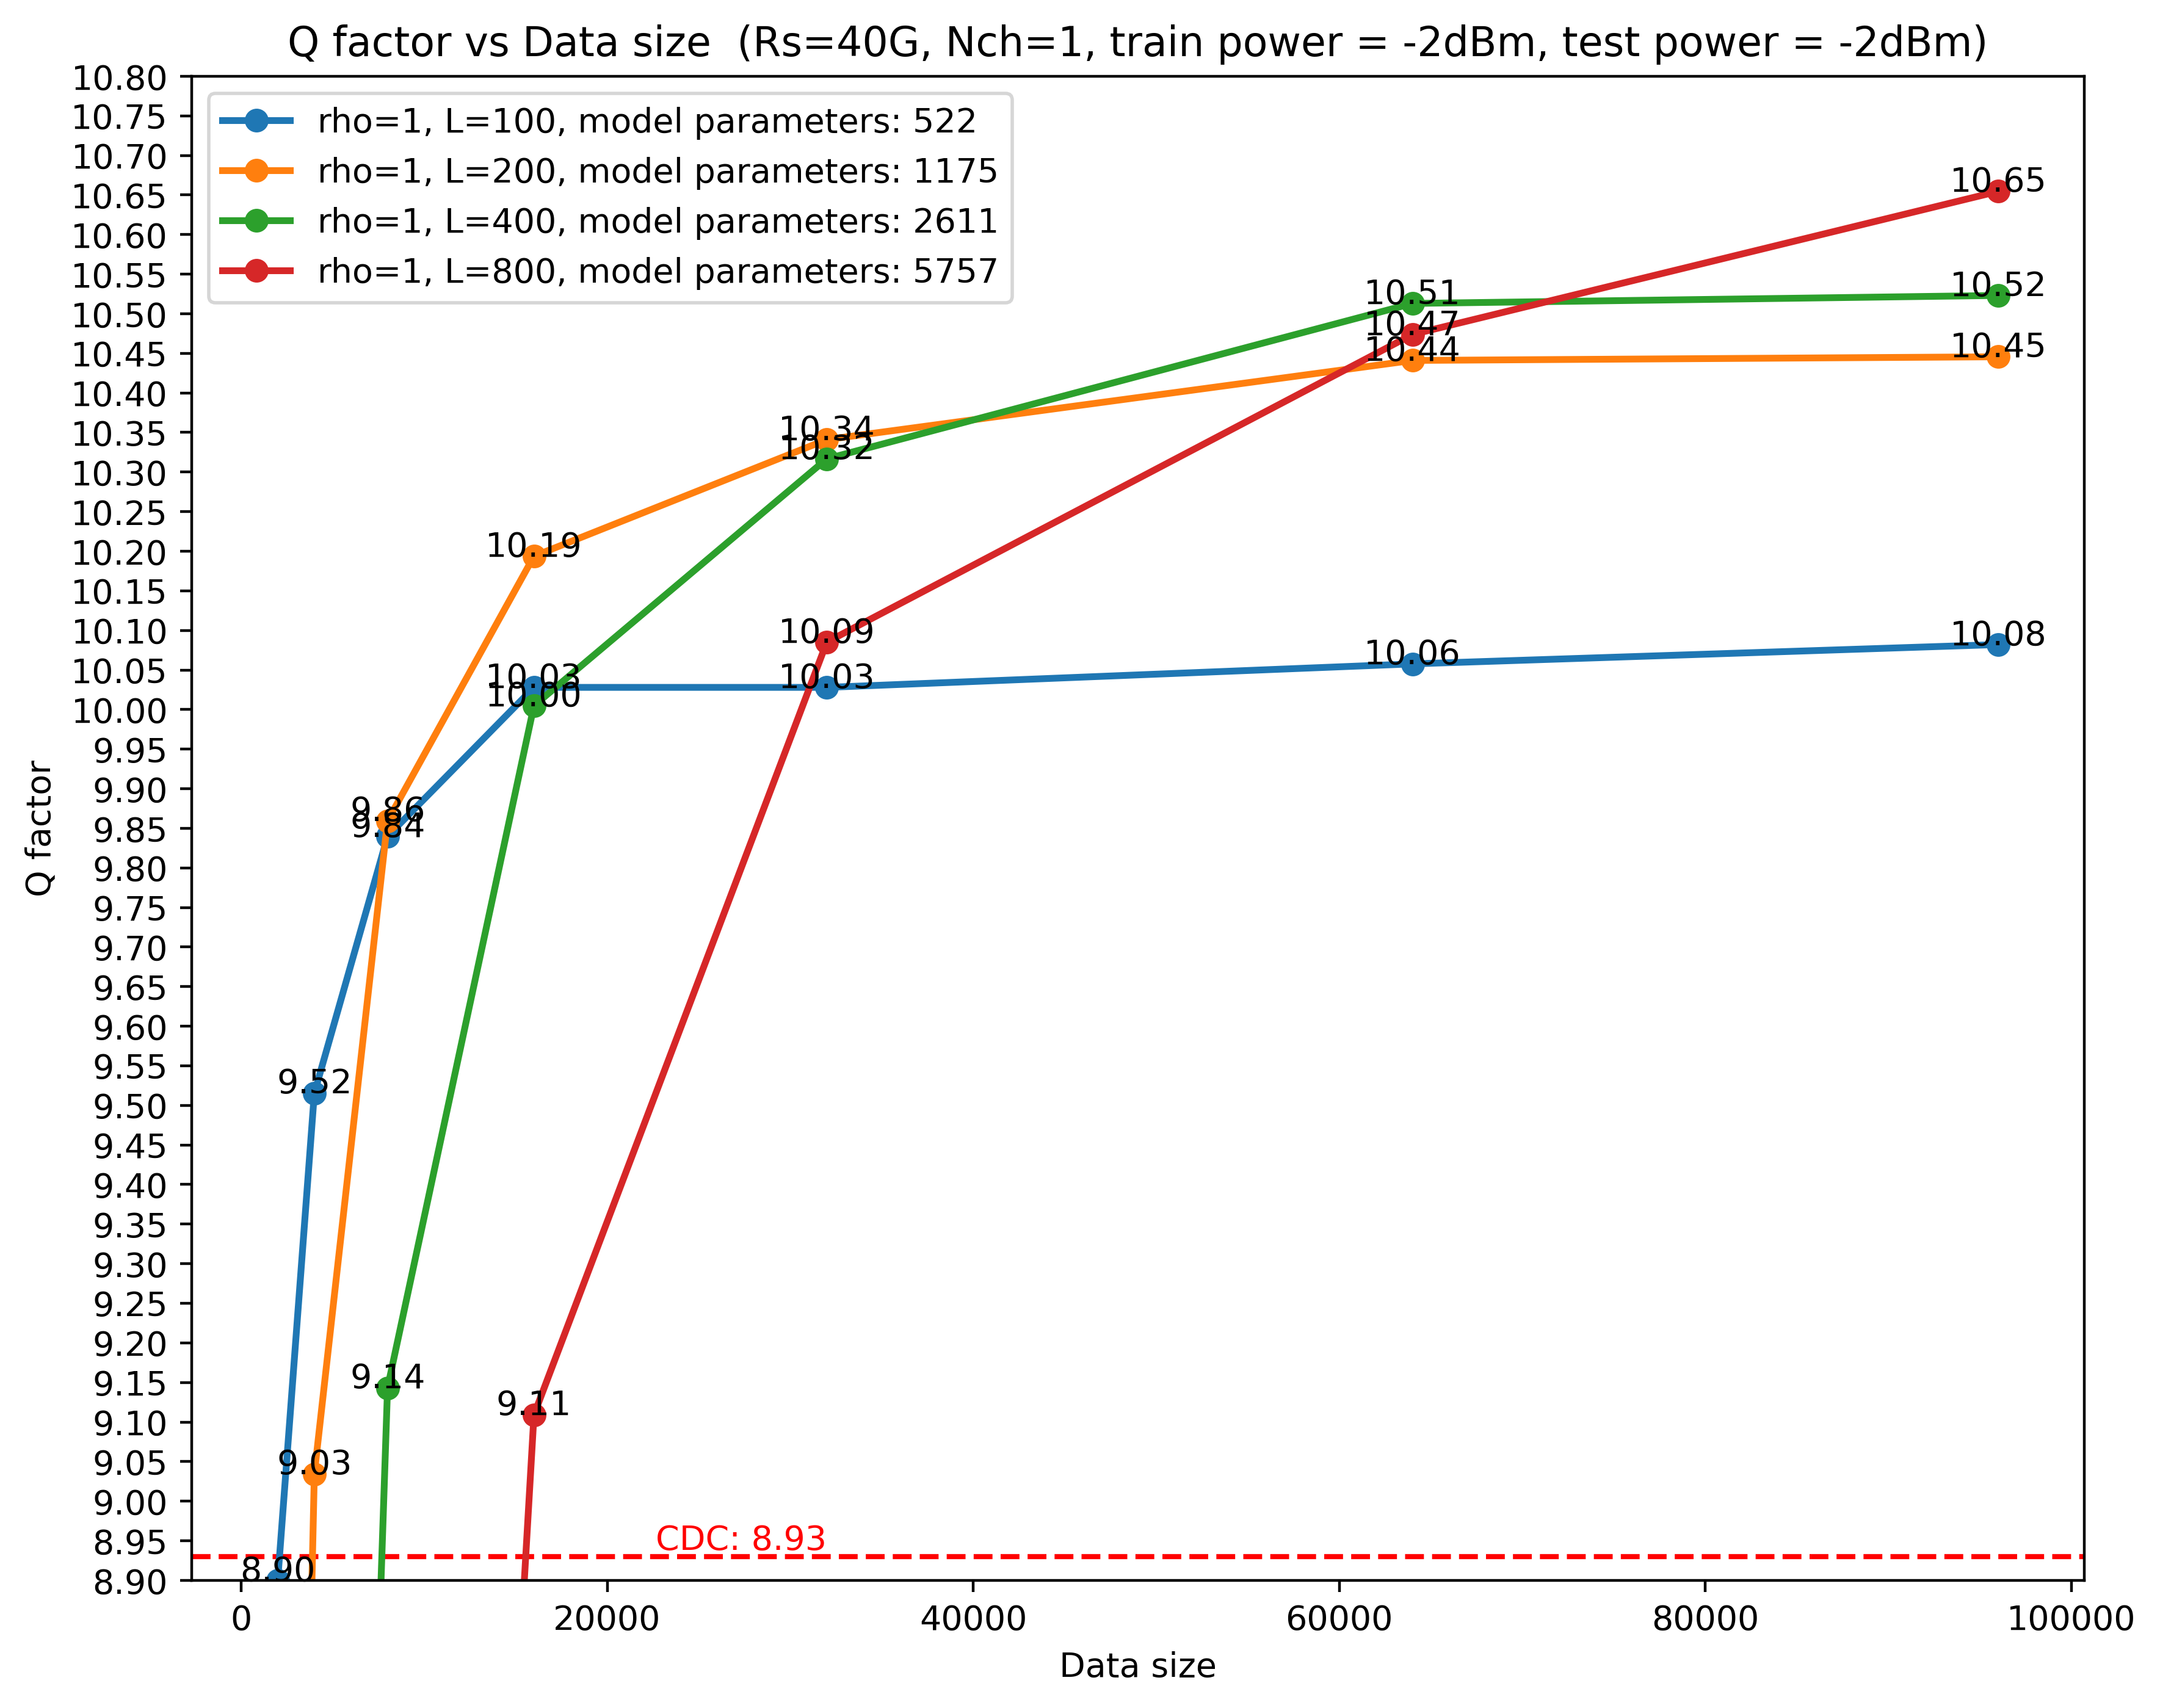

In [84]:
from src.TorchDSP.dataloader import get_Qsq, getQsq_fromdir, mean_peak

plt.figure(figsize=(10,8), dpi=400)
Ds = 2*np.array([1000, 2000, 4000, 8000, 16000, 32000, 48000])
Ls = [100, 200, 400, 800]

# Take CDC result as baseline
Q1,Rs,Nch,P = get_Qsq('./outputs/Qfactor/Q2000/baselines.pkl', discard=10000)
cdc = Q1['CDC'][1, 0,:]
baseline = cdc[6,0]
plt.axhline(y=baseline, color='r', linestyle='--')
plt.text(Ds[4], baseline, f'CDC: {baseline:.2f}', ha='right', va='bottom', color='r')

# Take data and plot
res = pickle.load(open(f'_outputs/res/res_D_L_Tr-2_Te-2.pkl', 'rb'))
y_range = [8.9, 10.8]

for L in Ls:
    Qs = np.array([res[f'Q1 D={d} L={L}'] for d in Ds])                                         # get Qfactor
    p = len(NonlienarFeatures(Nmodes=1, rho=1, L = L, index_type='reduce-1').index)          # calc number of features
    plt.plot(Ds, Qs, '-o',linewidth=2, label=f'rho={1}, L={L}, model parameters: {p}')       # plot

    for i, value in enumerate(Qs):
        if Qs[i] >= y_range[0] and Qs[i] <= y_range[1]:
            plt.text(Ds[i], Qs[i], f'{value:.2f}', ha='center')             # annotate

plt.ylim(*y_range)
plt.yticks(np.arange(*y_range, 0.05))
plt.legend()
plt.xlabel('Data size')
plt.ylabel('Q factor')
plt.title('Q factor vs Data size  (Rs=40G, Nch=1, train power = -2dBm, test power = -2dBm)')

Text(0.5, 1.0, 'Q factor vs Data size  (Rs=40G, Nch=1, train power = 0dBm, test power = -2dBm)')

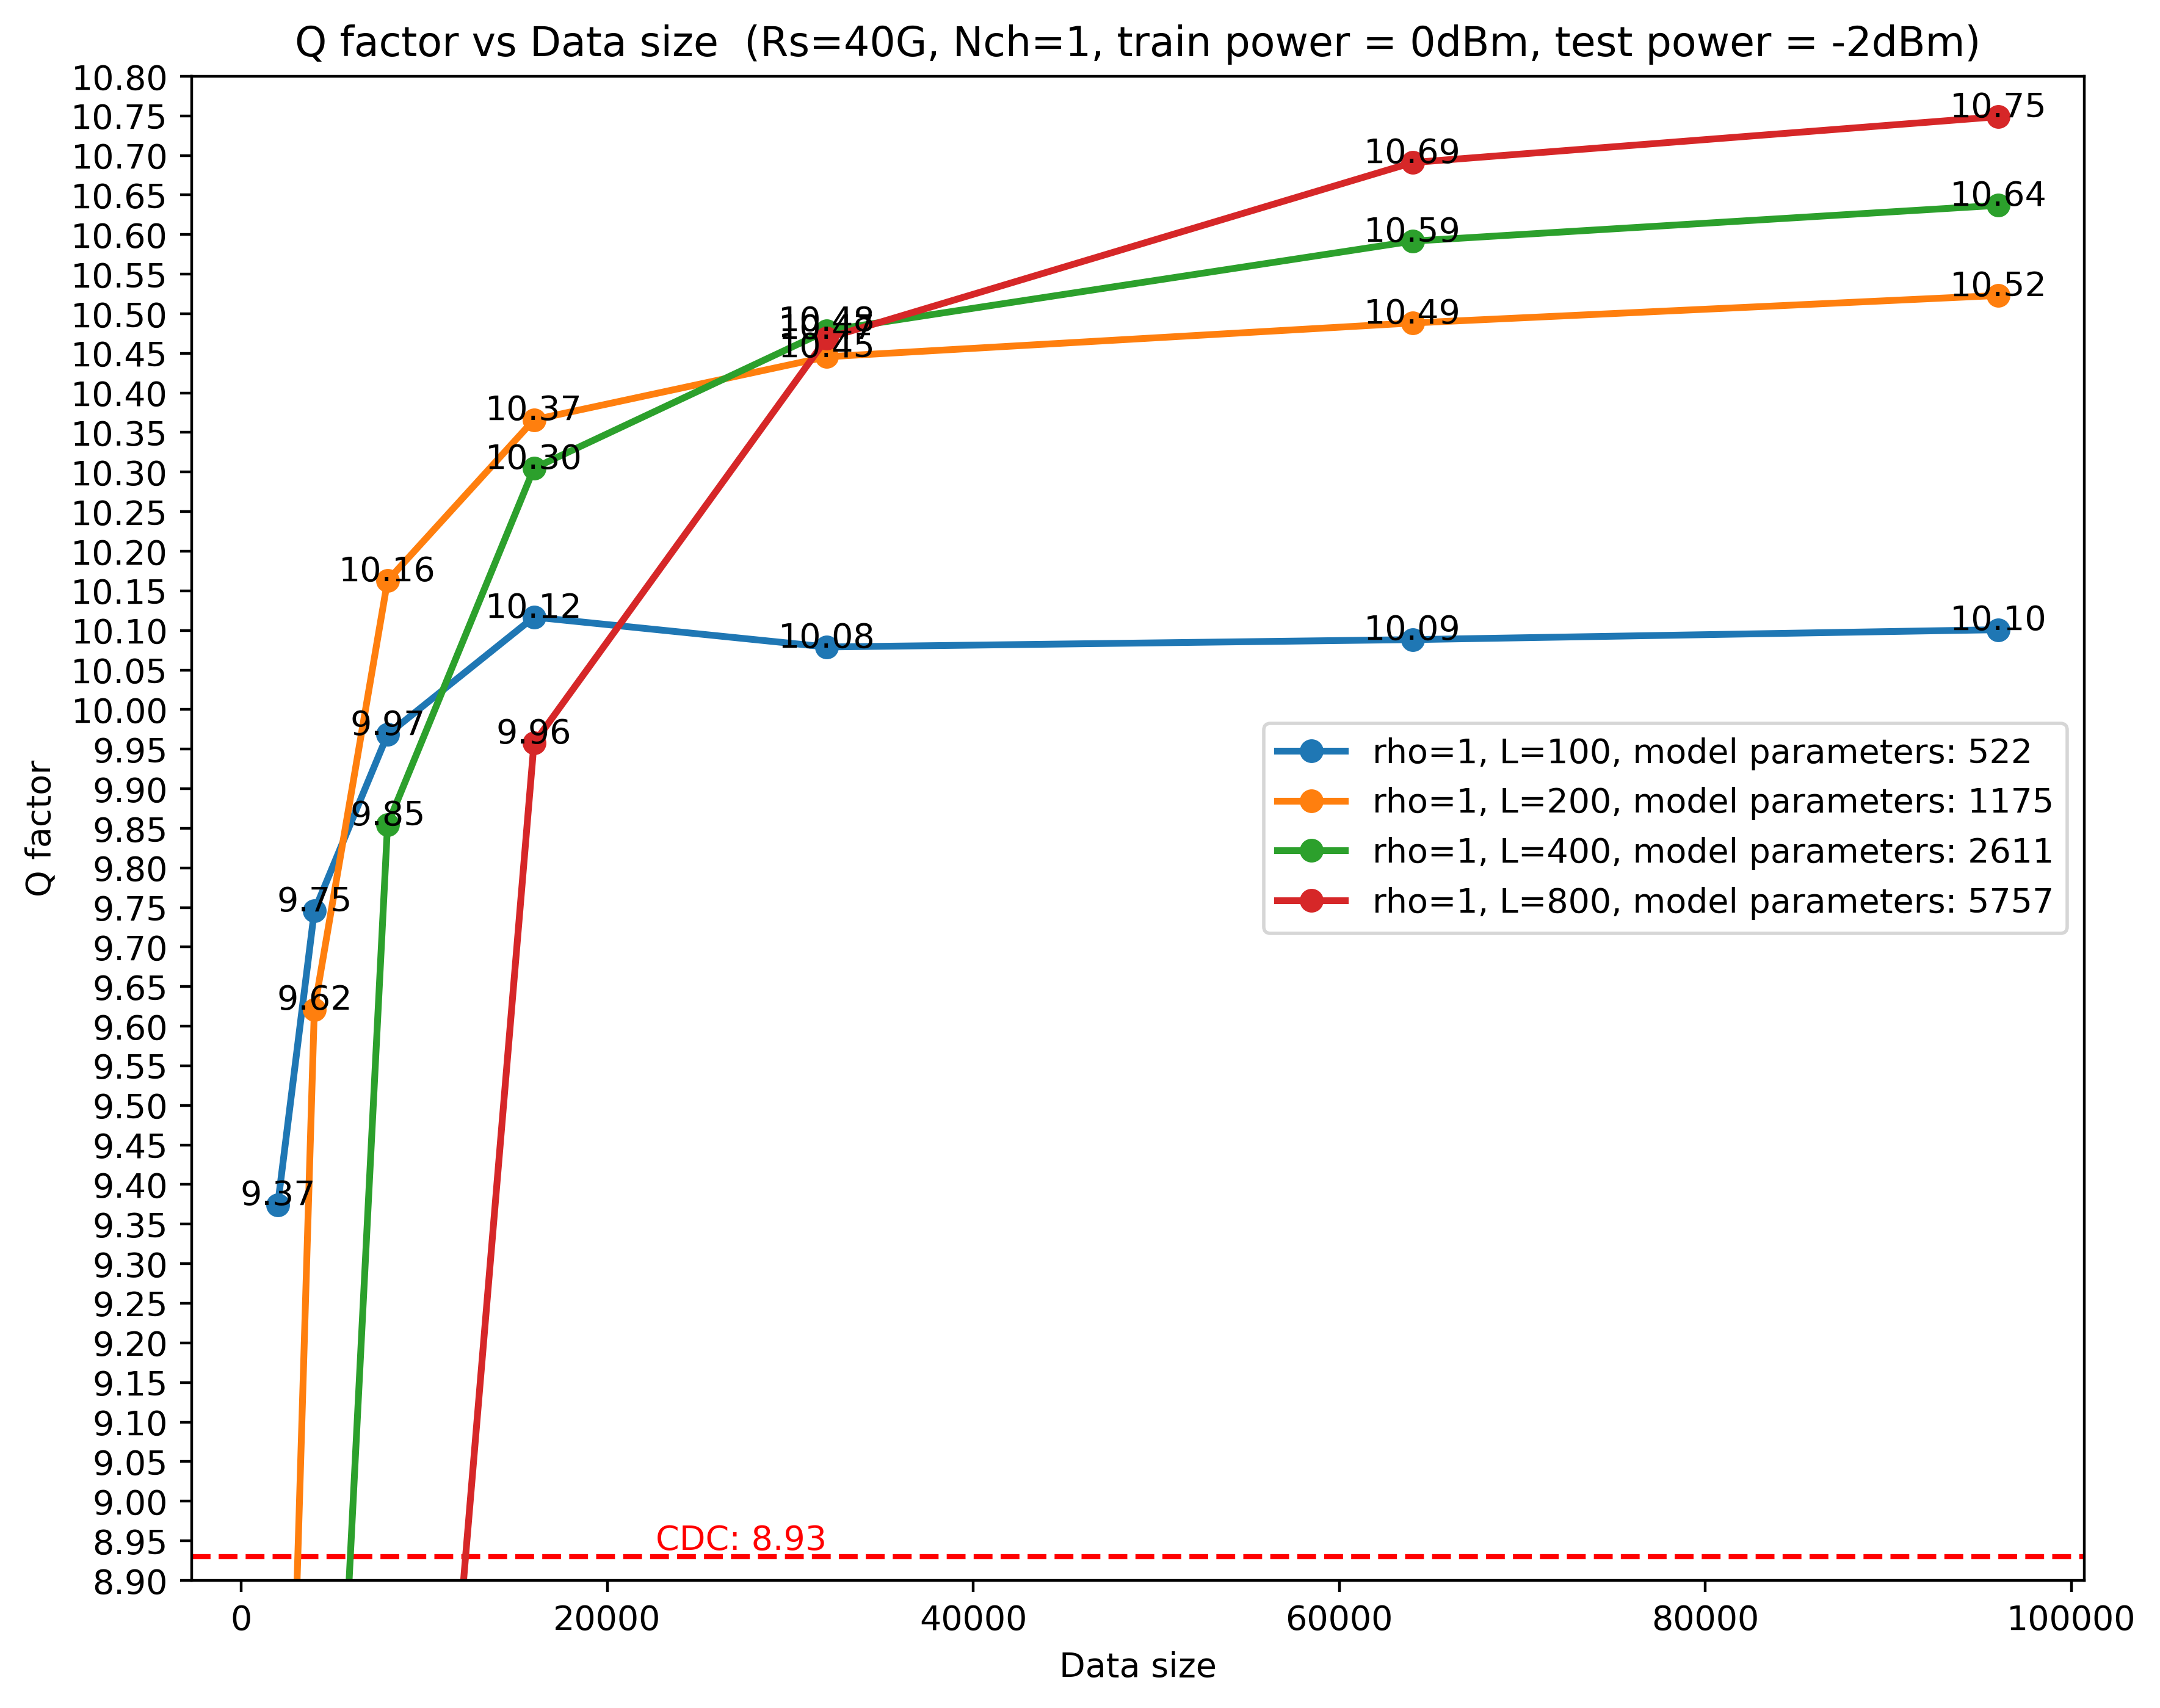

In [4]:
import pickle , matplotlib.pyplot as plt, torch, numpy as np, argparse, time, os, scipy
from src.TorchDSP.dataloader import get_Qsq, getQsq_fromdir, mean_peak

plt.figure(figsize=(10,8), dpi=400)
Ds = 2*np.array([1000, 2000, 4000, 8000, 16000, 32000, 48000])
Ls = [100, 200, 400, 800]

# Take CDC result as baseline
Q1,Rs,Nch,P = get_Qsq('./outputs/Qfactor/Q2000/baselines.pkl', discard=10000)
cdc = Q1['CDC'][1, 0,:]
baseline = cdc[6,0]
plt.axhline(y=baseline, color='r', linestyle='--')
plt.text(Ds[4], baseline, f'CDC: {baseline:.2f}', ha='right', va='bottom', color='r')

# Take data and plot
res = pickle.load(open(f'_outputs/res/res_D_L_Tr0_Te-2.pkl', 'rb'))
y_range = [8.9, 10.8]

for L in Ls:
    Qs = np.array([res[f'Q1 D={d} L={L}'] for d in Ds])                                         # get Qfactor
    p = len(NonlienarFeatures(Nmodes=1, rho=1, L = L, index_type='reduce-1').index)          # calc number of features
    plt.plot(Ds, Qs, '-o', linewidth=2, label=f'rho={1}, L={L}, model parameters: {p}')       # plot

    for i, value in enumerate(Qs):
        if Qs[i] >= y_range[0] and Qs[i] <= y_range[1]:
            plt.text(Ds[i], Qs[i], f'{value:.2f}', ha='center')             # annotate

plt.ylim(*y_range)
plt.yticks(np.arange(*y_range, 0.05))
plt.legend()
plt.xlabel('Data size')
plt.ylabel('Q factor')
plt.title('Q factor vs Data size  (Rs=40G, Nch=1, train power = 0dBm, test power = -2dBm)')

In [5]:
res.keys()

dict_keys(['Q1 D=700 L=100', 'xis D=700 L=100', 'MSE D=700 L=100', 'Ls D=700 L=100', 'Qs D=700 L=100', 'Q1 D=1400 L=100', 'xis D=1400 L=100', 'MSE D=1400 L=100', 'Ls D=1400 L=100', 'Qs D=1400 L=100', 'Q1 D=1750 L=100', 'xis D=1750 L=100', 'MSE D=1750 L=100', 'Ls D=1750 L=100', 'Qs D=1750 L=100', 'Q1 D=3500 L=100', 'xis D=3500 L=100', 'MSE D=3500 L=100', 'Ls D=3500 L=100', 'Qs D=3500 L=100', 'Q1 D=7000 L=100', 'xis D=7000 L=100', 'MSE D=7000 L=100', 'Ls D=7000 L=100', 'Qs D=7000 L=100', 'Q1 D=14000 L=100', 'xis D=14000 L=100', 'MSE D=14000 L=100', 'Ls D=14000 L=100', 'Qs D=14000 L=100', 'Q1 D=28000 L=100', 'xis D=28000 L=100', 'MSE D=28000 L=100', 'Ls D=28000 L=100', 'Qs D=28000 L=100', 'Q1 D=56000 L=100', 'xis D=56000 L=100', 'MSE D=56000 L=100', 'Ls D=56000 L=100', 'Qs D=56000 L=100', 'Q1 D=112000 L=100', 'xis D=112000 L=100', 'MSE D=112000 L=100', 'Ls D=112000 L=100', 'Qs D=112000 L=100', 'Q1 D=224000 L=100', 'xis D=224000 L=100', 'MSE D=224000 L=100', 'Ls D=224000 L=100', 'Qs D=2240

In [16]:
res = pickle.load(open(f'res_D_L_Tr[0]_Te[-2]_large.pkl', 'rb'))
np.squeeze(res[f'Q1 D={700} L={100}'])

array(6.4688134, dtype=float32)

Text(0.5, 1.0, 'Q factor vs Data size  (Rs=40G, Nch=1, train power = 0dBm, test power = -2dBm)')

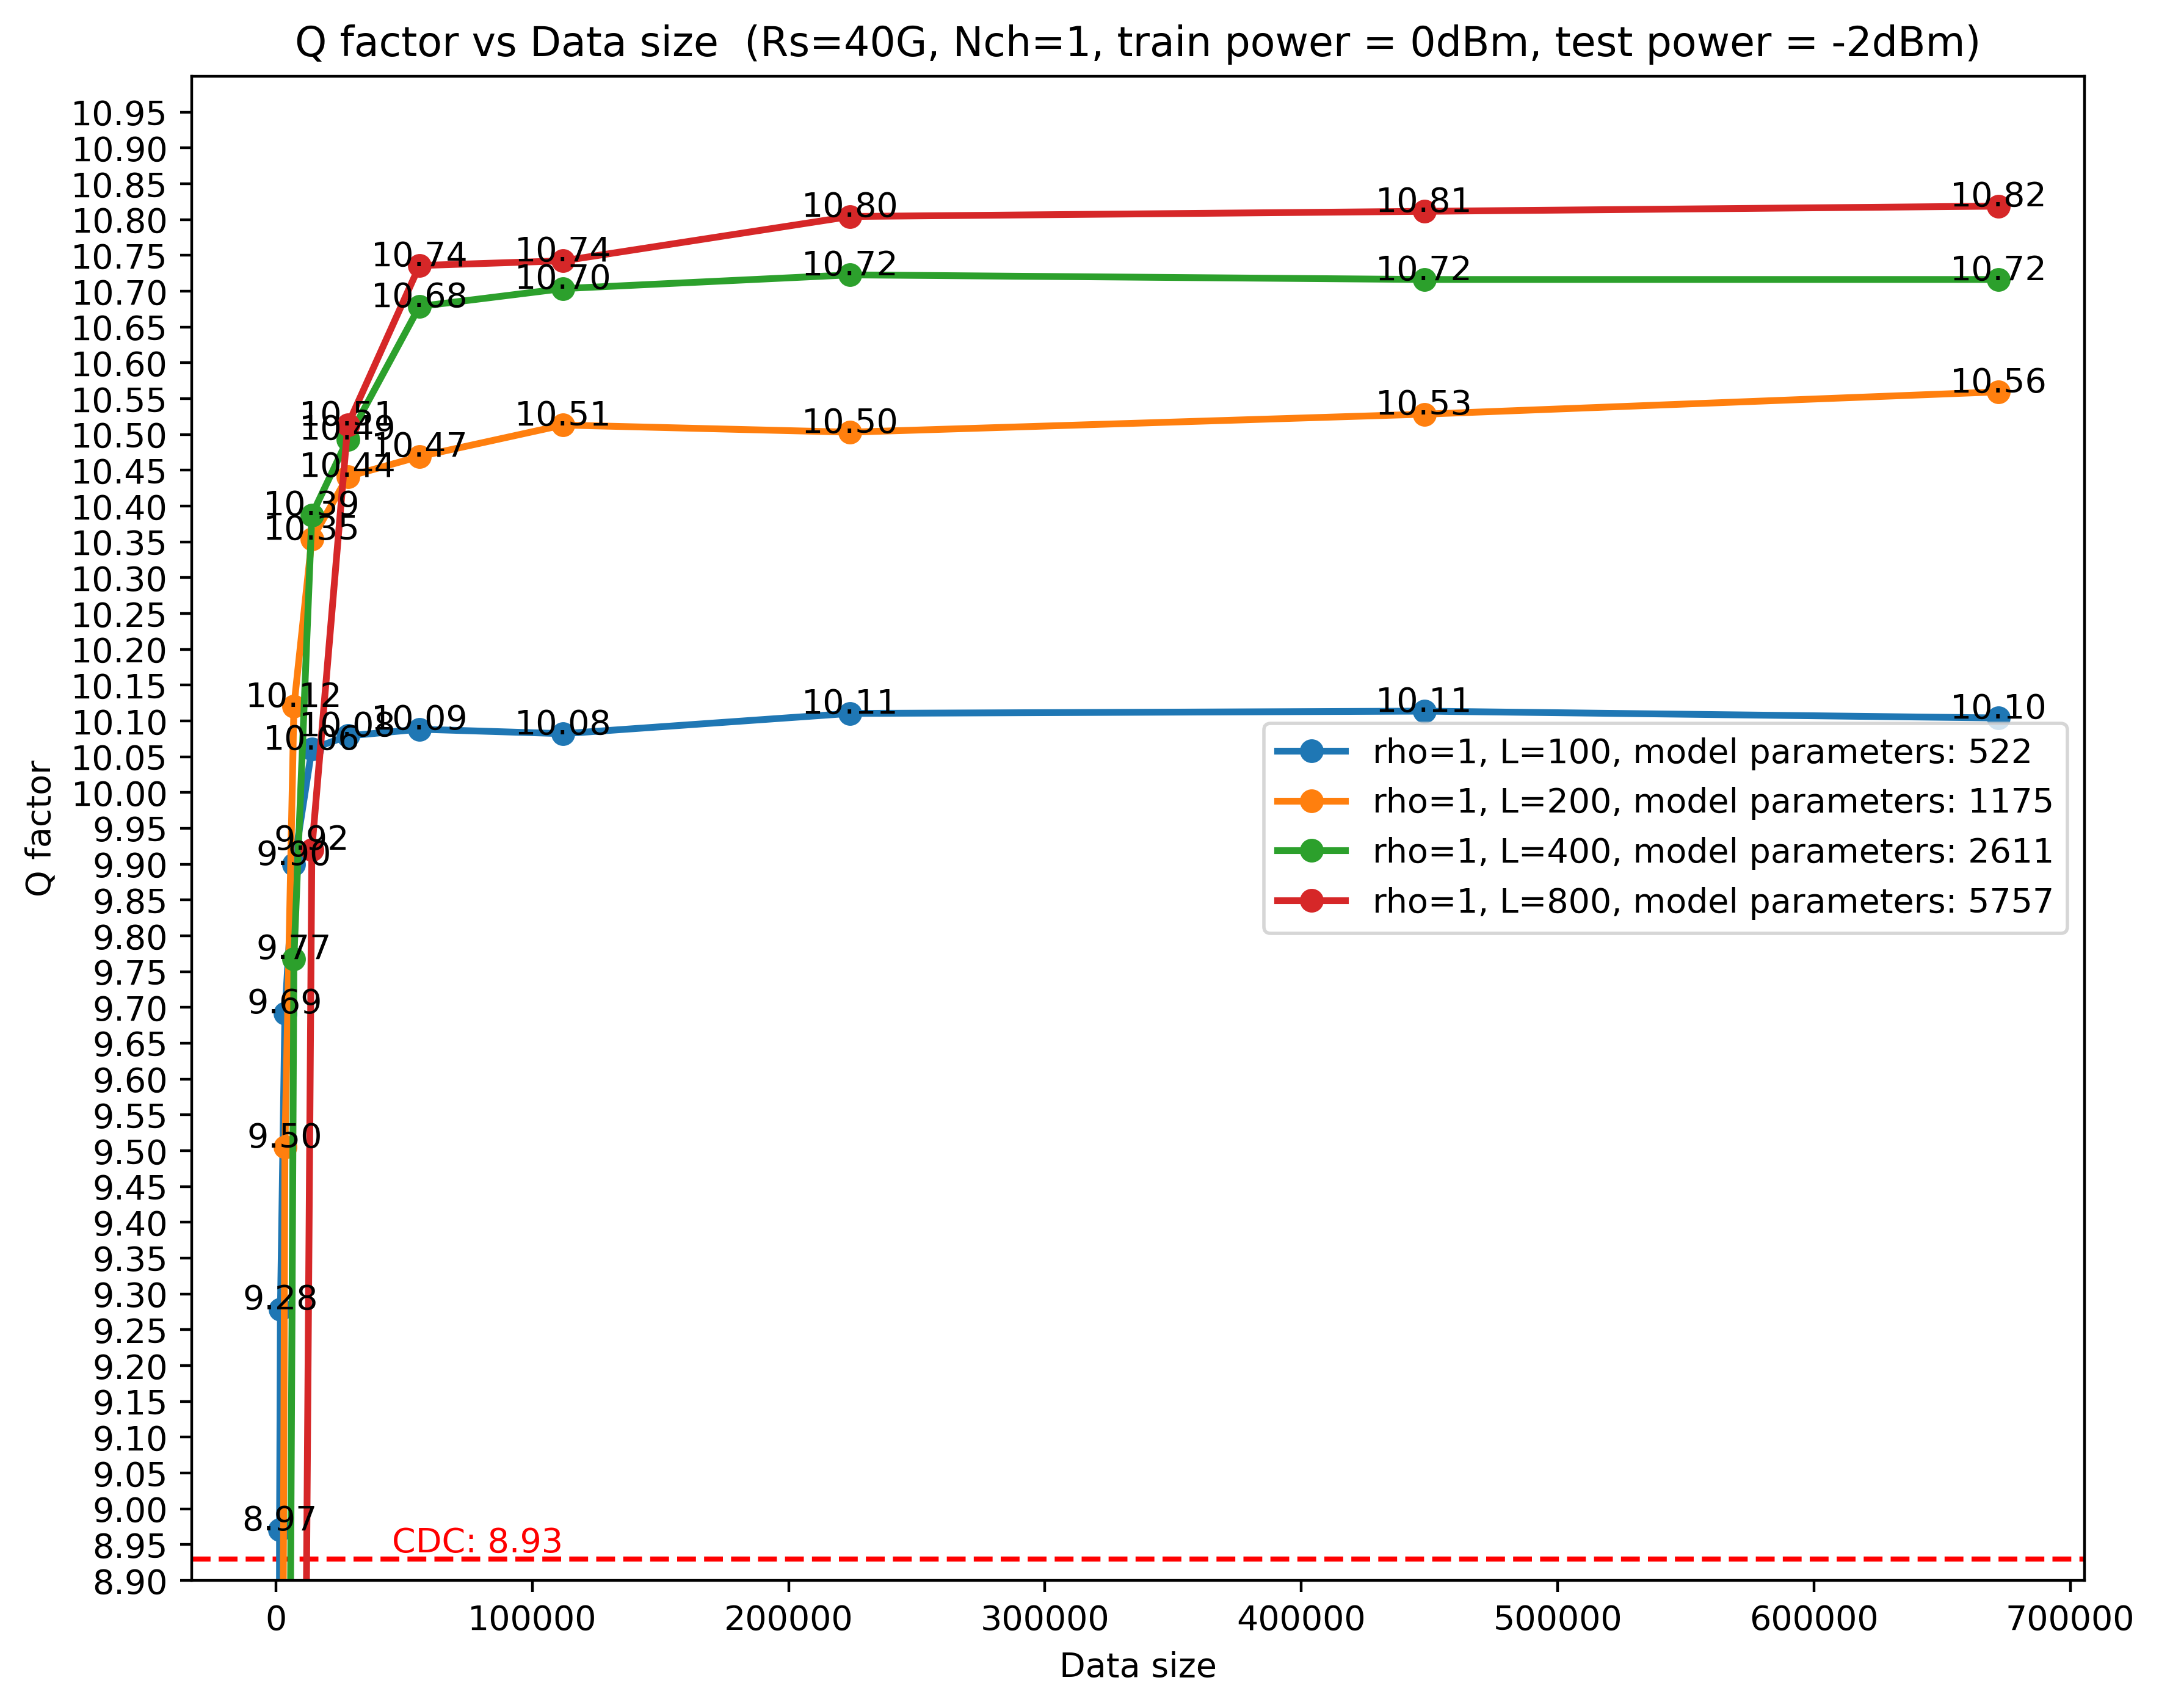

In [5]:
from src.TorchDSP.dataloader import get_Qsq, getQsq_fromdir, mean_peak

plt.figure(figsize=(10,8), dpi=400)
Ds = np.array([50, 100, 125, 250, 500, 1000, 2000, 4000, 8000, 16000, 32000, 48000])*14
Ls = np.array([100, 200, 400, 800])

# Take CDC result as baseline
Q1,Rs,Nch,P = get_Qsq('./outputs/Qfactor/Q2000/baselines.pkl', discard=10000)
cdc = Q1['CDC'][1, 0,:]
baseline = cdc[6,0]
plt.axhline(y=baseline, color='r', linestyle='--')
plt.text(Ds[8], baseline, f'CDC: {baseline:.2f}', ha='right', va='bottom', color='r')

# Take data and plot
res = pickle.load(open(f'res_D_L_Tr[0]_Te[-2]_large.pkl', 'rb'))
y_range = [8.9, 11]

for L in Ls:
    Qs = np.array([np.squeeze(res[f'Q1 D={d} L={L}']) for d in Ds])                                         # get Qfactor
    p = len(NonlienarFeatures(Nmodes=1, rho=1, L = L, index_type='reduce-1').index)          # calc number of features
    plt.plot(Ds, Qs, '-o', linewidth=2, label=f'rho={1}, L={L}, model parameters: {p}')       # plot

    for i, value in enumerate(Qs):
        if Qs[i] >= y_range[0] and Qs[i] <= y_range[1]:
            plt.text(Ds[i], Qs[i], f'{value:.2f}', ha='center')             # annotate

plt.ylim(*y_range)
plt.yticks(np.arange(*y_range, 0.05))
plt.legend()
plt.xlabel('Data size')
plt.ylabel('Q factor')
plt.title('Q factor vs Data size  (Rs=40G, Nch=1, train power = 0dBm, test power = -2dBm)')

Text(0.5, 1.0, 'Q factor vs Data size  (Rs=40G, Nch=1, train power = -2dBm, test power = -2dBm)')

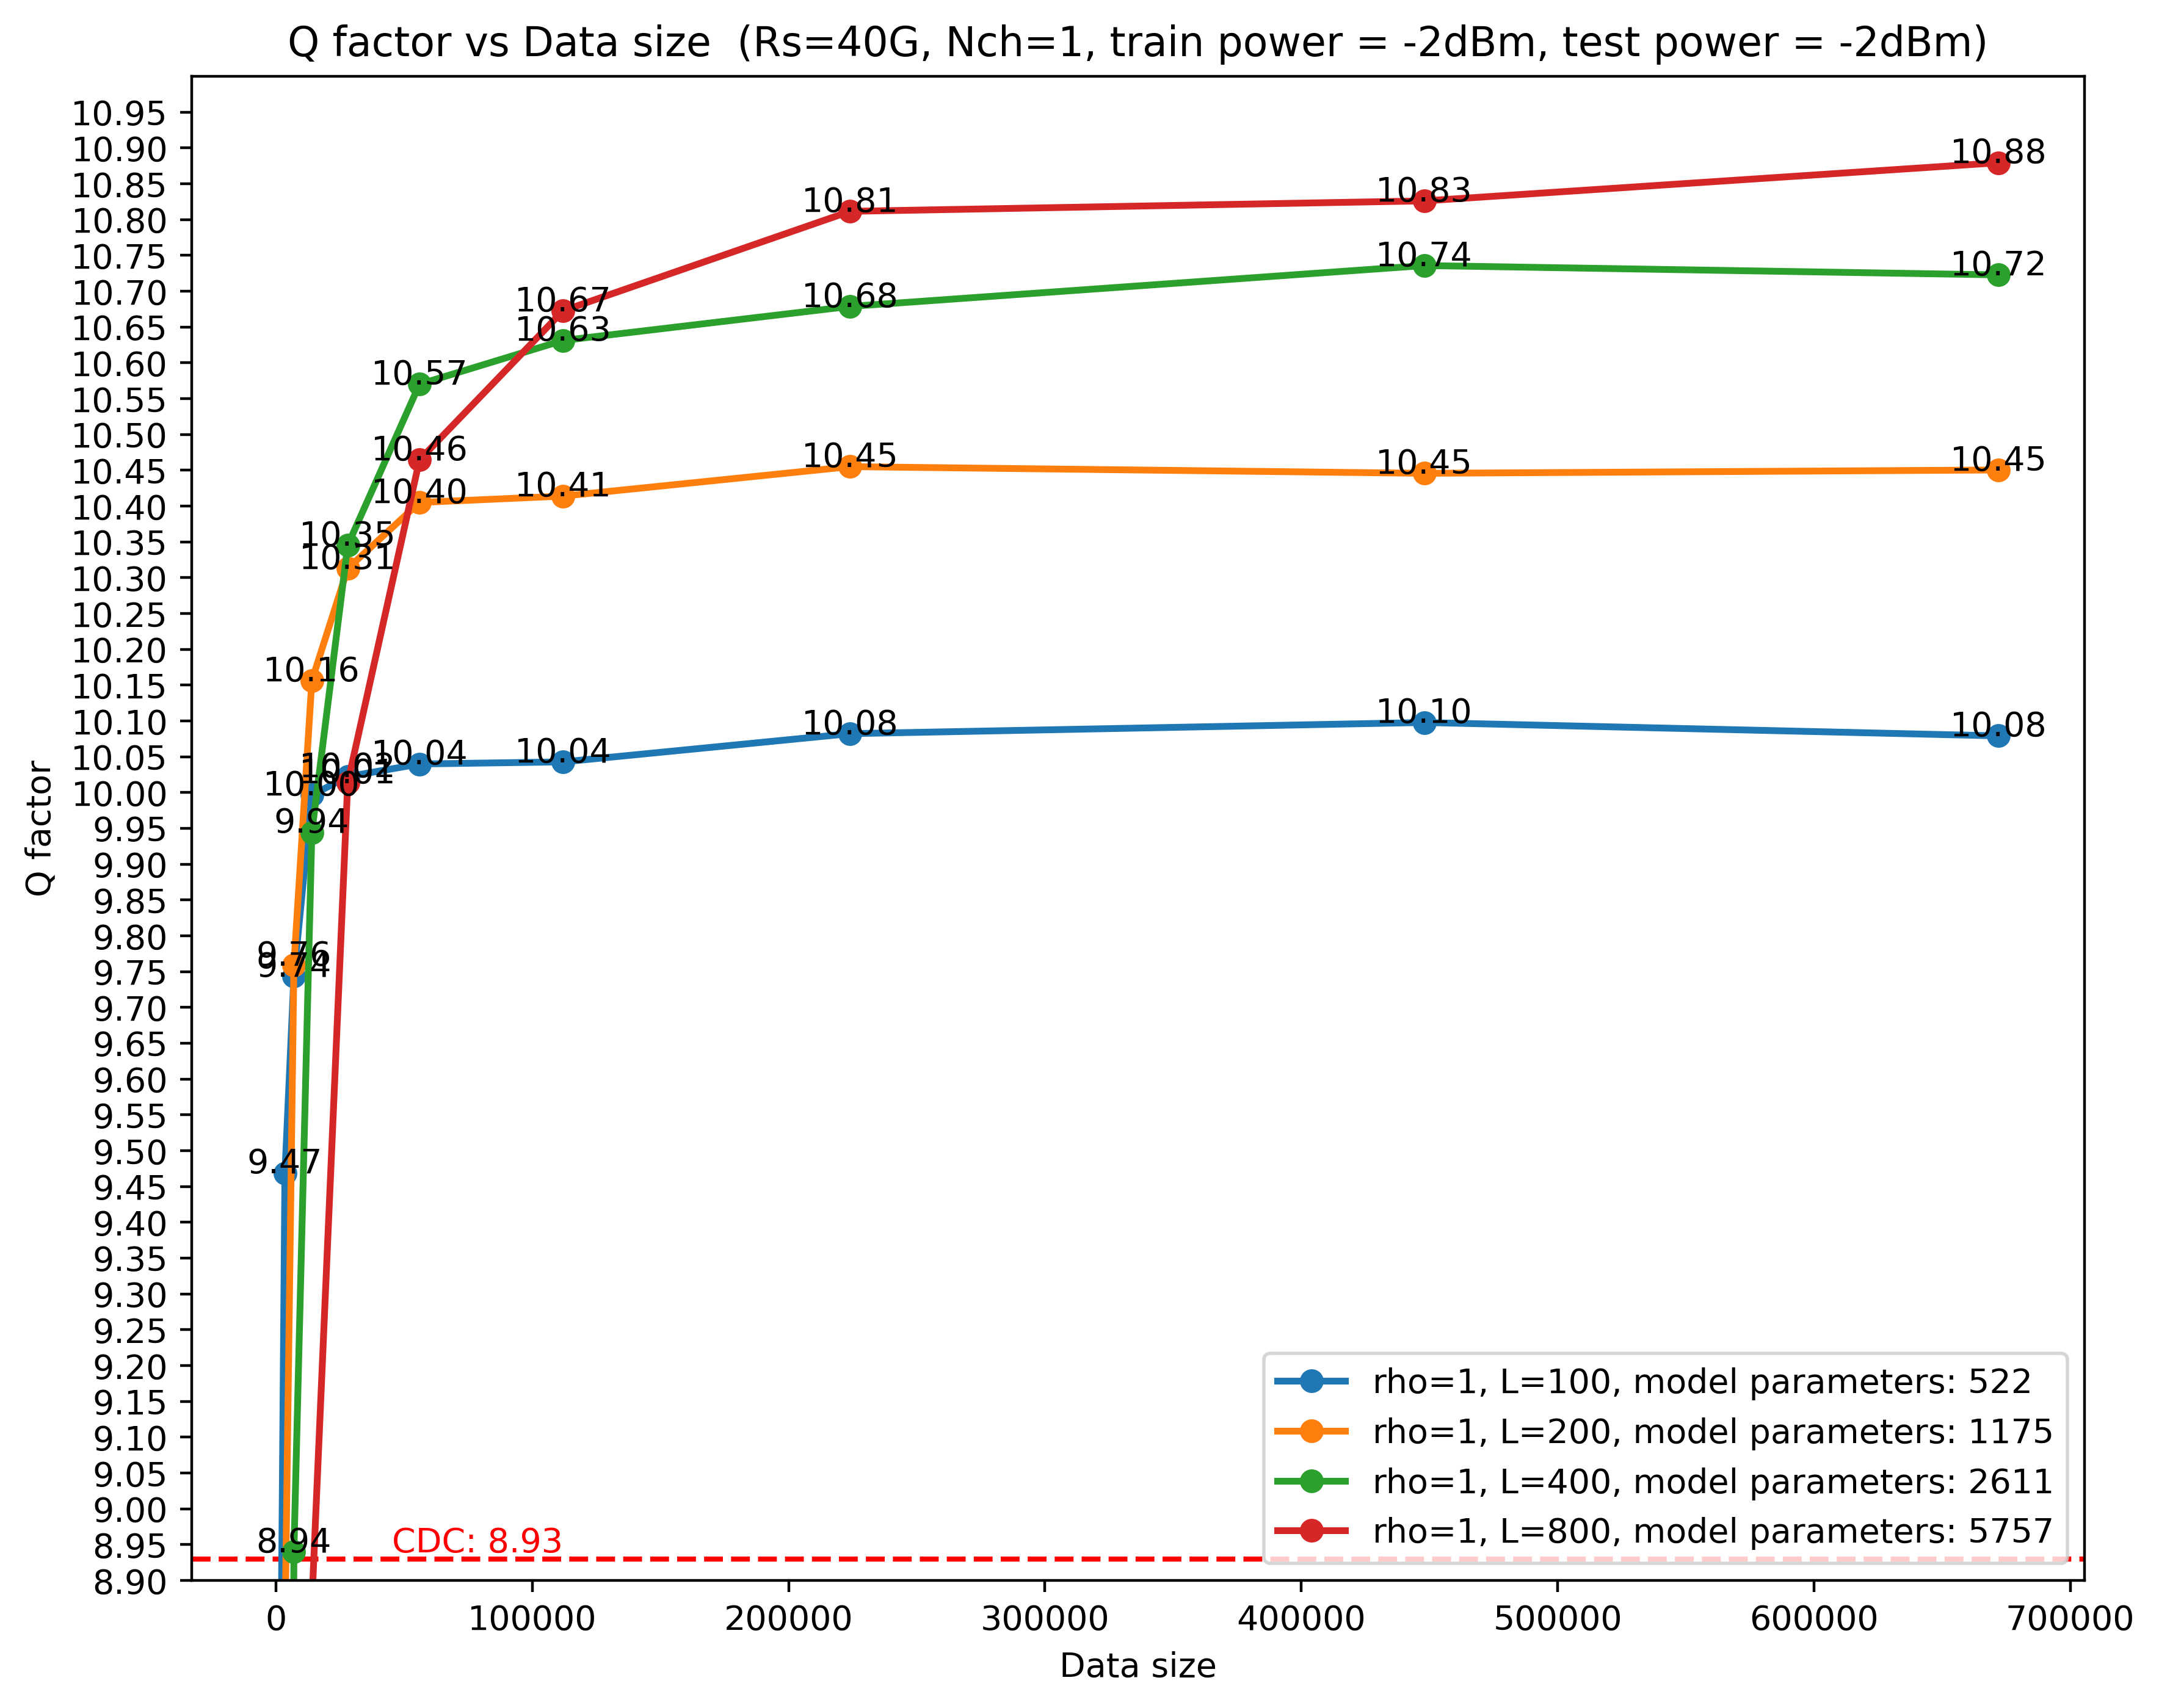

In [9]:
from src.TorchDSP.dataloader import get_Qsq, getQsq_fromdir, mean_peak

plt.figure(figsize=(10,8), dpi=400)
Ds = np.array([50, 100, 125, 250, 500, 1000, 2000, 4000, 8000, 16000, 32000, 48000])*14
Ls = np.array([100, 200, 400, 800])

# Take CDC result as baseline
Q1,Rs,Nch,P = get_Qsq('./outputs/Qfactor/Q2000/baselines.pkl', discard=10000)
cdc = Q1['CDC'][1, 0,:]
baseline = cdc[6,0]
plt.axhline(y=baseline, color='r', linestyle='--')
plt.text(Ds[8], baseline, f'CDC: {baseline:.2f}', ha='right', va='bottom', color='r')

# Take data and plot
res = pickle.load(open(f'res_D_L_large.pkl', 'rb'))
y_range = [8.9, 11]

for L in Ls:
    Qs = np.array([np.squeeze(res[f'Q1 D={d} L={L} train_p=[-2] test_p=[-2]']) for d in Ds])                                         # get Qfactor
    p = len(NonlienarFeatures(Nmodes=1, rho=1, L = L, index_type='reduce-1').index)          # calc number of features
    plt.plot(Ds, Qs, '-o', linewidth=2, label=f'rho={1}, L={L}, model parameters: {p}')       # plot

    for i, value in enumerate(Qs):
        if Qs[i] >= y_range[0] and Qs[i] <= y_range[1]:
            plt.text(Ds[i], Qs[i], f'{value:.2f}', ha='center')             # annotate

plt.ylim(*y_range)
plt.yticks(np.arange(*y_range, 0.05))
plt.legend()
plt.xlabel('Data size')
plt.ylabel('Q factor')
plt.title('Q factor vs Data size  (Rs=40G, Nch=1, train power = -2dBm, test power = -2dBm)')

# Trainp-test P

In [24]:
res = pickle.load(open('_outputs/res/res_TrTe_L400_D96000.pkl', 'rb'))

P = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3,4,5,6]
Q = np.zeros((len(P), len(P)))

for i, tr in enumerate(P):
    Q[i,:] = res[f'Q1 tr={tr}'][0,:,0]

Text(0, 0.5, 'train power')

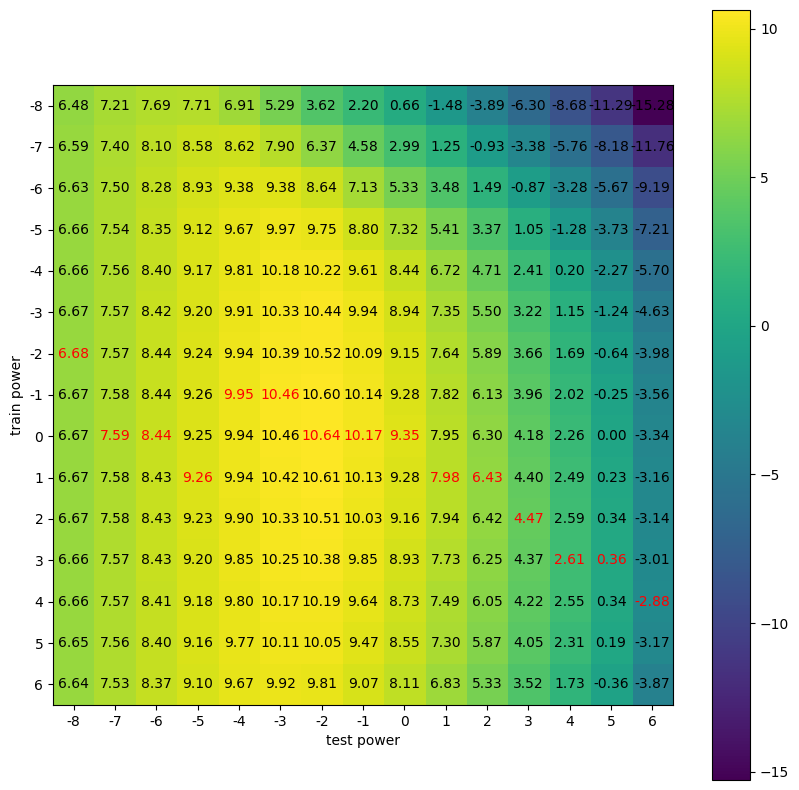

In [28]:
# write the number into each position, index the max value in each column
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(Q, cmap= 'viridis')
# annotate the number
for i in range(len(P)):
    for j in range(len(P)):
        if i == np.argmax(Q, axis=0)[j]:
            plt.text(j, i, f'{Q[i,j]:.2f}', ha='center', va='center', color='r')
        else:
            plt.text(j, i, f'{Q[i,j]:.2f}', ha='center', va='center', color='k')


# # set the color bar range 
# plt.clim(, 10.7)
# add color bar
plt.colorbar()

plt.xticks(np.arange(len(P)), P)
plt.yticks(np.arange(len(P)), P)
plt.xlabel('test power')
plt.ylabel('train power')

In [7]:
import numpy as np, pickle, matplotlib.pyplot as plt
from scipy import special

def Qsq_inv(y):
    return 0.5 * special.erfc(10**(y / 20) / np.sqrt(2))

In [5]:
res = pickle.load(open(f'_outputs/res/res_D_L_Tr0_Te-2.pkl', 'rb'))

Ds = 2*np.array([1000, 2000, 4000, 8000, 16000, 32000, 48000])
Ls =  np.arange(100, 900, 100)

Q = np.zeros([len(Ds), len(Ls)])
Ber = np.zeros([len(Ds), len(Ls)])
for i, d in enumerate(Ds):
    for j, L in enumerate(Ls):
        Q[i,j] = res[f'Q1 D={d} L={L}']
        Ber[i,j] = Qsq_inv(Q[i,j])

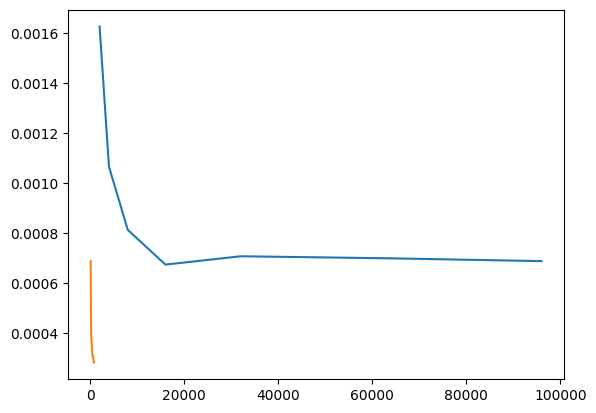

In [9]:
plt.plot(Ds, Ber[:,0])
plt.plot(Ls, Ber[-1])

In [35]:
import torch


ckpt1 = torch.load('_models/up_scale_Rs40_Nch1_Pch-2/AmFoPBC.ckpt200', map_location='cpu')
ckpt2 = torch.load('_models/up_scale_Rs40_Nch1_Pch-2/FoPBC_new.ckpt200', map_location='cpu')
ckpt3 = torch.load('_models/up_scale_Rs40_Nch1_Pch-2/MultiStep.ckpt30', map_location='cpu')

print(' AMPBC: ')
print('BER:', ckpt1['metric']['BER'][6])
print('Qsq:', ckpt1['metric']['Qsq'][6])
print('SNR:', ckpt1['metric']['SNR'][6])


print('\n PBC: ')
print('BER:', ckpt2['metric']['BER'][6])
print('Qsq:', ckpt2['metric']['Qsq'][6])
print('SNR:', ckpt2['metric']['SNR'][6])

print('\n MultiStep: ')
print('BER:', ckpt3['metric']['BER'][6])
print('Qsq:', ckpt3['metric']['Qsq'][6])
print('SNR:', ckpt3['metric']['SNR'][6])

 AMPBC: 
BER: [0.00021304]
Qsq: [10.939182]
SNR: [17.776466]

 PBC: 
BER: [0.00024388]
Qsq: [10.850016]
SNR: [17.97716]

 MultiStep: 
BER: [0.0002178]
Qsq: [10.924732]
SNR: [17.836893]


10.85771 17.72678


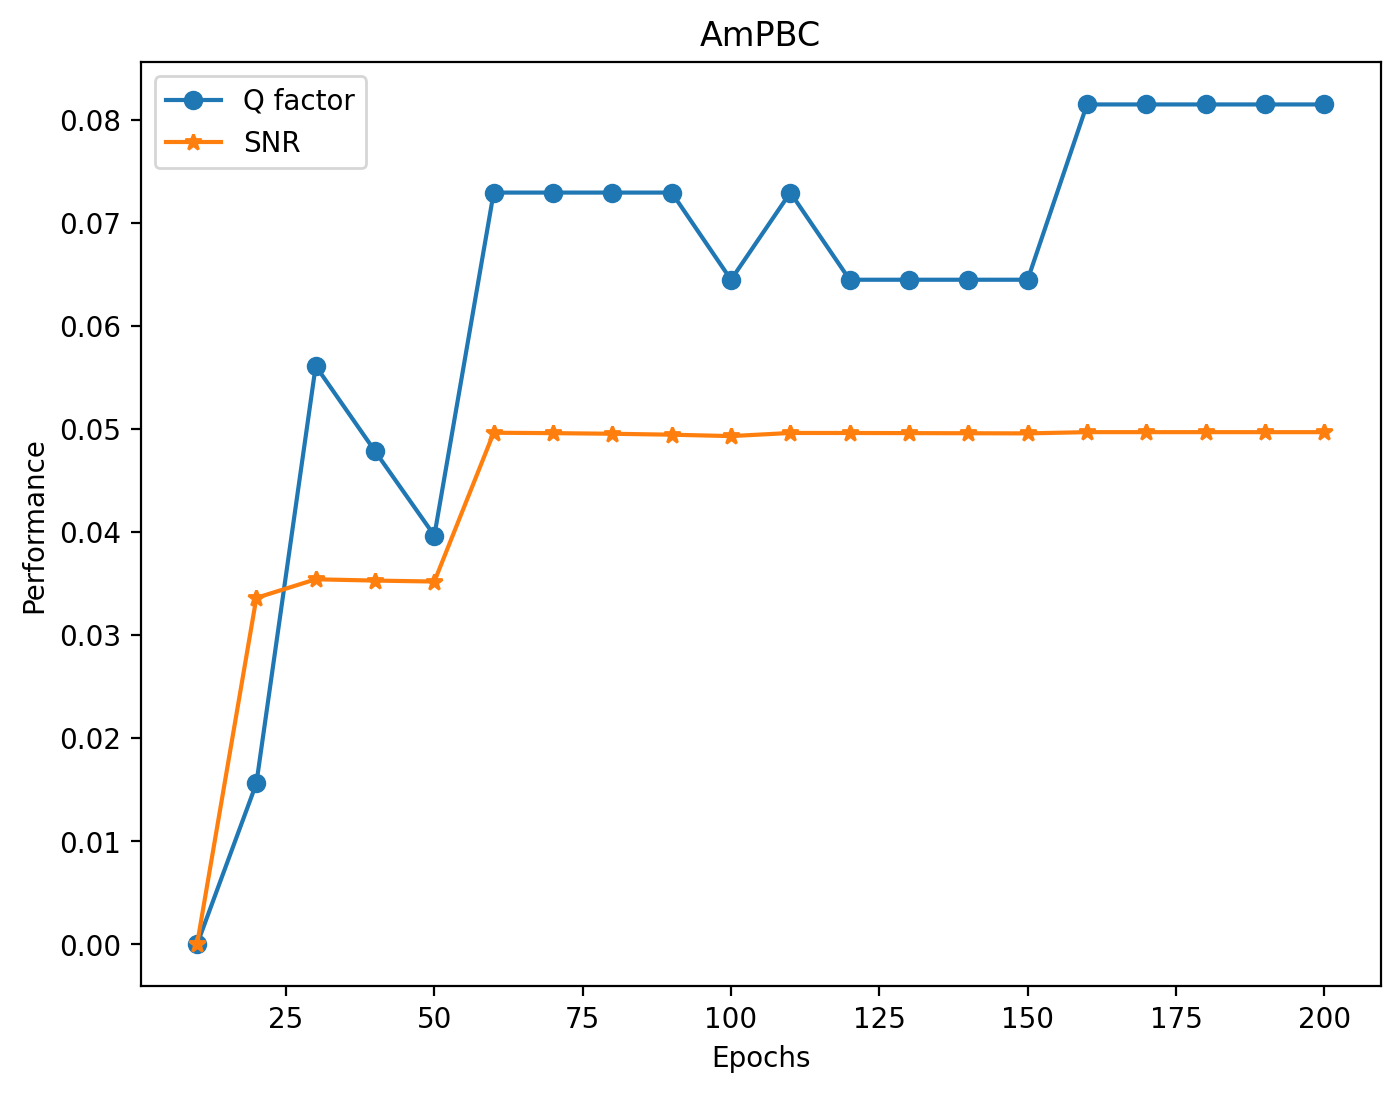

In [5]:
import torch, matplotlib.pyplot as plt, numpy as np

Q  = []
SNR = []
epochs = range(10, 210, 10)
for i in epochs:
    ckpt1 = torch.load(f'_models/up_scale_Rs40_Nch1_Pch-2/AmFoPBC.ckpt{i}', map_location='cpu')
    Q.append(ckpt1['metric']['Qsq'][6])
    SNR.append(ckpt1['metric']['SNR'][6])
Q = np.array(Q)
SNR = np.array(SNR)


plt.figure(figsize=(8,6), dpi=200)
plt.plot(epochs, Q - np.min(Q), '-o', label='Q factor')
plt.plot(epochs, SNR - np.min(SNR), '-*', label='SNR')
print(np.min(Q), np.min(SNR))
plt.xlabel('Epochs')
plt.ylabel('Performance')
plt.title('AmPBC')
plt.legend()

10.85771 17.72678


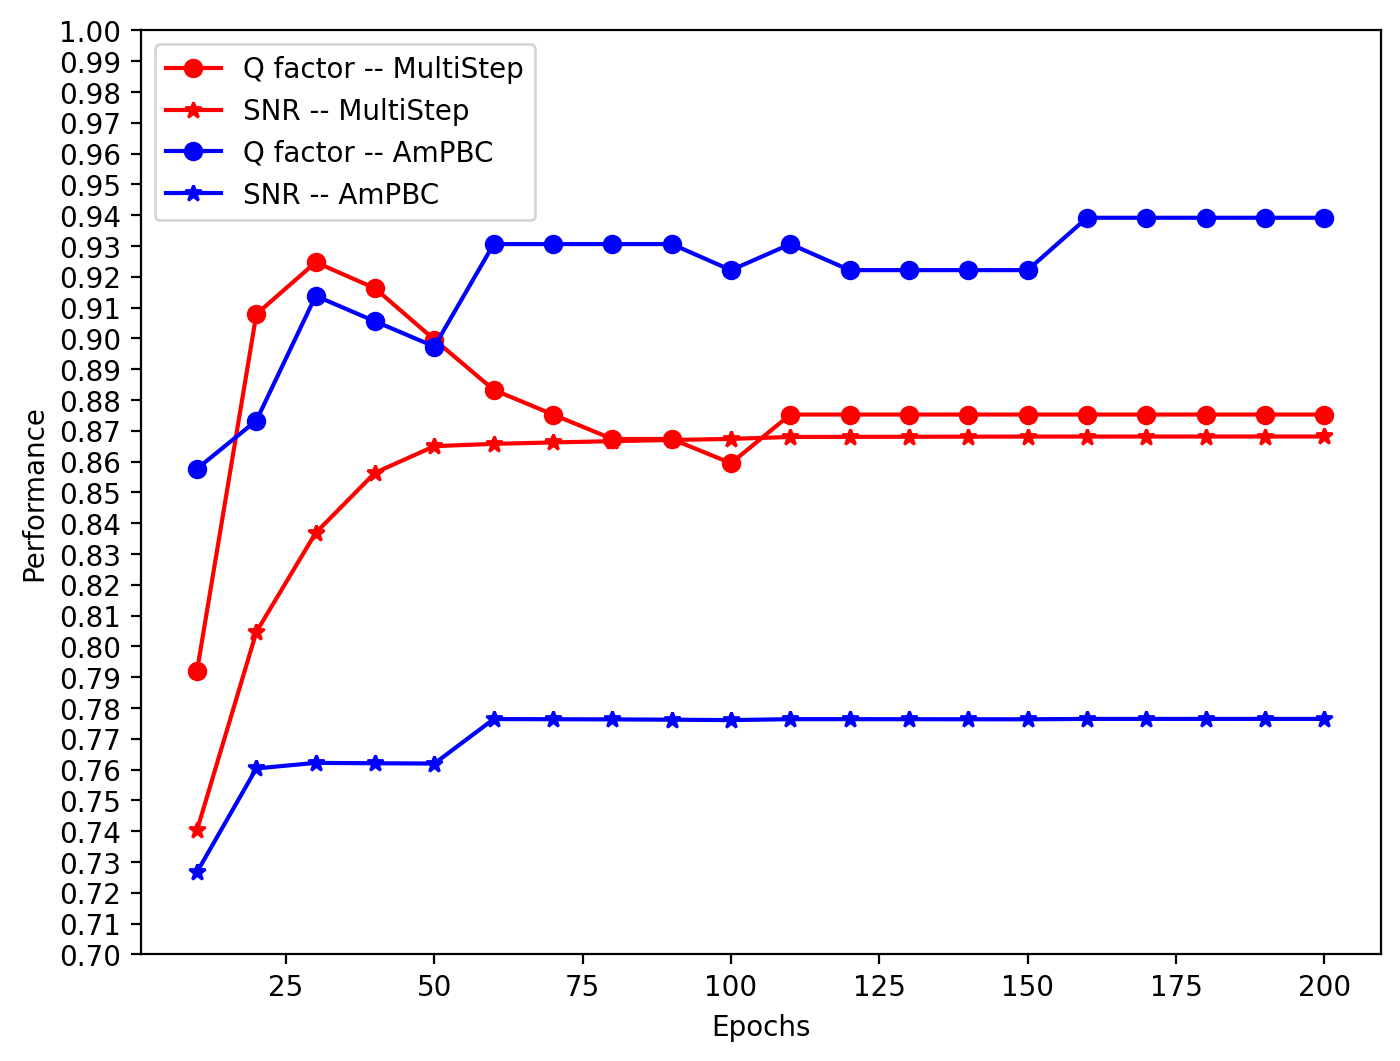

In [35]:
import torch, matplotlib.pyplot as plt, numpy as np

Q  = []
SNR = []
epochs = range(10, 210, 10)
for i in epochs:
    ckpt1 = torch.load(f'_models/up_scale_Rs40_Nch1_Pch-2/MultiStep.ckpt{i}', map_location='cpu')
    Q.append(ckpt1['metric']['Qsq'][6])
    SNR.append(ckpt1['metric']['SNR'][6])
Q = np.array(Q)
SNR = np.array(SNR)



plt.figure(figsize=(8,6), dpi=200)
plt.plot(epochs, Q - 10, '-o', color='r', label='Q factor -- MultiStep')
plt.plot(epochs, SNR - 17, '-*', color='r', label='SNR -- MultiStep')


Q  = []
SNR = []
epochs = range(10, 210, 10)
for i in epochs:
    ckpt1 = torch.load(f'_models/up_scale_Rs40_Nch1_Pch-2/AmFoPBC.ckpt{i}', map_location='cpu')
    Q.append(ckpt1['metric']['Qsq'][6])
    SNR.append(ckpt1['metric']['SNR'][6])
Q = np.array(Q)
SNR = np.array(SNR)


plt.plot(epochs, Q - 10, '-o', color='b', label='Q factor -- AmPBC')
plt.plot(epochs, SNR - 17, '-*', color='b', label='SNR -- AmPBC')
print(np.min(Q), np.min(SNR))
plt.xlabel('Epochs')
plt.ylabel('Performance')
plt.ylim(0.7, 1)
plt.yticks(np.arange(0.7, 1, 0.01))
plt.legend()

10.85771 17.71653


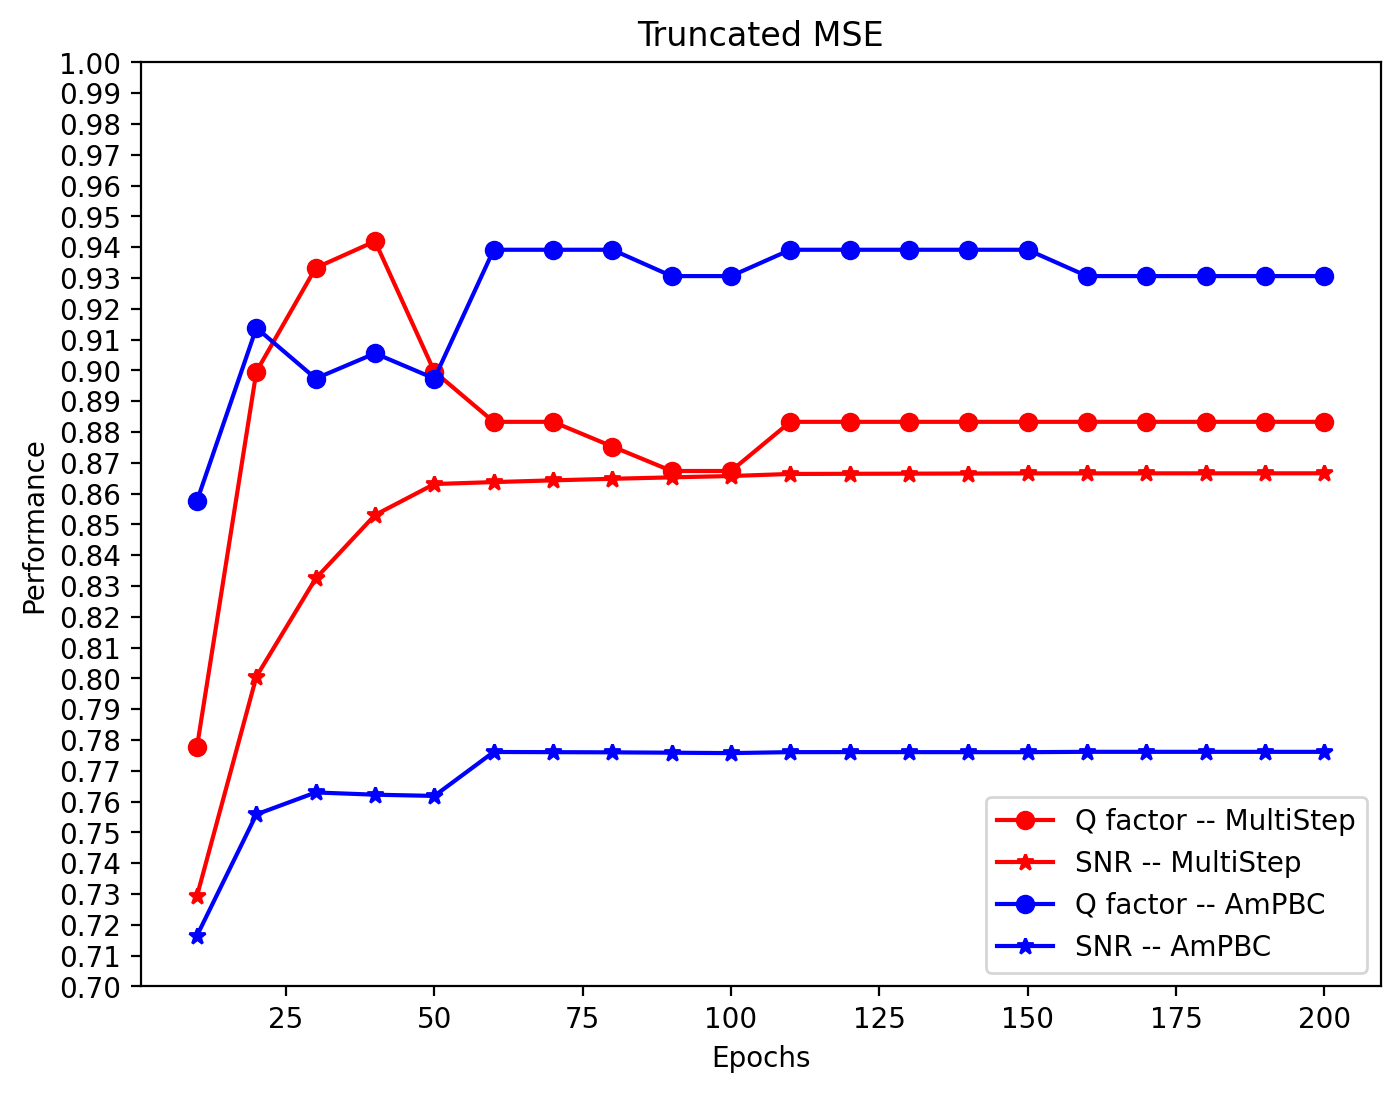

In [33]:
import torch, matplotlib.pyplot as plt, numpy as np

Q  = []
SNR = []
epochs = range(10, 210, 10)
for i in epochs:
    ckpt1 = torch.load(f'_models/up_scale_Rs40_Nch1_Pch-2_loss3/MultiStep.ckpt{i}', map_location='cpu')
    Q.append(ckpt1['metric']['Qsq'][6])
    SNR.append(ckpt1['metric']['SNR'][6])
Q = np.array(Q)
SNR = np.array(SNR)



plt.figure(figsize=(8,6), dpi=200)
plt.plot(epochs, Q - 10, '-o', color='r', label='Q factor -- MultiStep')
plt.plot(epochs, SNR - 17, '-*', color='r', label='SNR -- MultiStep')


Q  = []
SNR = []
epochs = range(10, 210, 10)
for i in epochs:
    ckpt1 = torch.load(f'_models/up_scale_Rs40_Nch1_Pch-2_loss3/AmFoPBC.ckpt{i}', map_location='cpu')
    Q.append(ckpt1['metric']['Qsq'][6])
    SNR.append(ckpt1['metric']['SNR'][6])
Q = np.array(Q)
SNR = np.array(SNR)


plt.plot(epochs, Q - 10, '-o', color='b', label='Q factor -- AmPBC')
plt.plot(epochs, SNR - 17, '-*', color='b', label='SNR -- AmPBC')
print(np.min(Q), np.min(SNR))
plt.xlabel('Epochs')
plt.ylabel('Performance')
plt.ylim(0.7, 1)
plt.yticks(np.arange(0.7, 1, 0.01))
plt.title('Truncated MSE')
plt.legend()

10.805382 17.698423


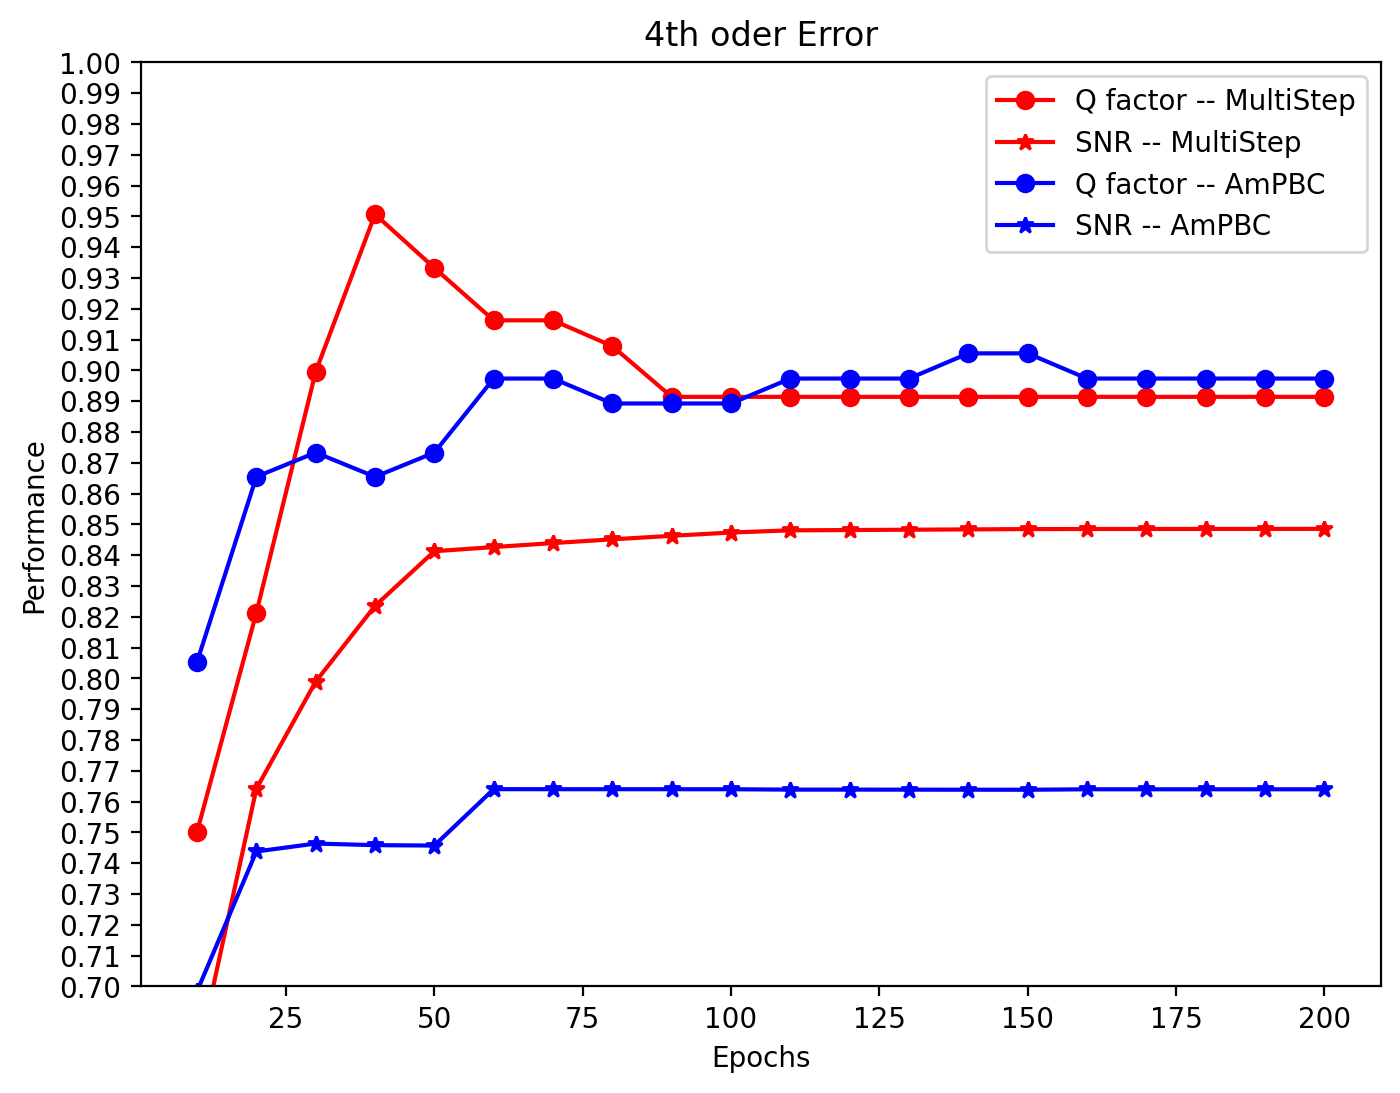

In [34]:
import torch, matplotlib.pyplot as plt, numpy as np

Q  = []
SNR = []
epochs = range(10, 210, 10)
for i in epochs:
    ckpt1 = torch.load(f'_models/up_scale_Rs40_Nch1_Pch-2_loss4/MultiStep.ckpt{i}', map_location='cpu')
    Q.append(ckpt1['metric']['Qsq'][6])
    SNR.append(ckpt1['metric']['SNR'][6])
Q = np.array(Q)
SNR = np.array(SNR)



plt.figure(figsize=(8,6), dpi=200)
plt.plot(epochs, Q - 10, '-o', color='r', label='Q factor -- MultiStep')
plt.plot(epochs, SNR - 17, '-*', color='r', label='SNR -- MultiStep')


Q  = []
SNR = []
epochs = range(10, 210, 10)
for i in epochs:
    ckpt1 = torch.load(f'_models/up_scale_Rs40_Nch1_Pch-2_loss4/AmFoPBC.ckpt{i}', map_location='cpu')
    Q.append(ckpt1['metric']['Qsq'][6])
    SNR.append(ckpt1['metric']['SNR'][6])
Q = np.array(Q)
SNR = np.array(SNR)


plt.plot(epochs, Q - 10, '-o', color='b', label='Q factor -- AmPBC')
plt.plot(epochs, SNR - 17, '-*', color='b', label='SNR -- AmPBC')
print(np.min(Q), np.min(SNR))
plt.xlabel('Epochs')
plt.ylabel('Performance')
plt.title('4th oder Error')
plt.ylim(0.7, 1)
plt.yticks(np.arange(0.7, 1, 0.01))
plt.legend()

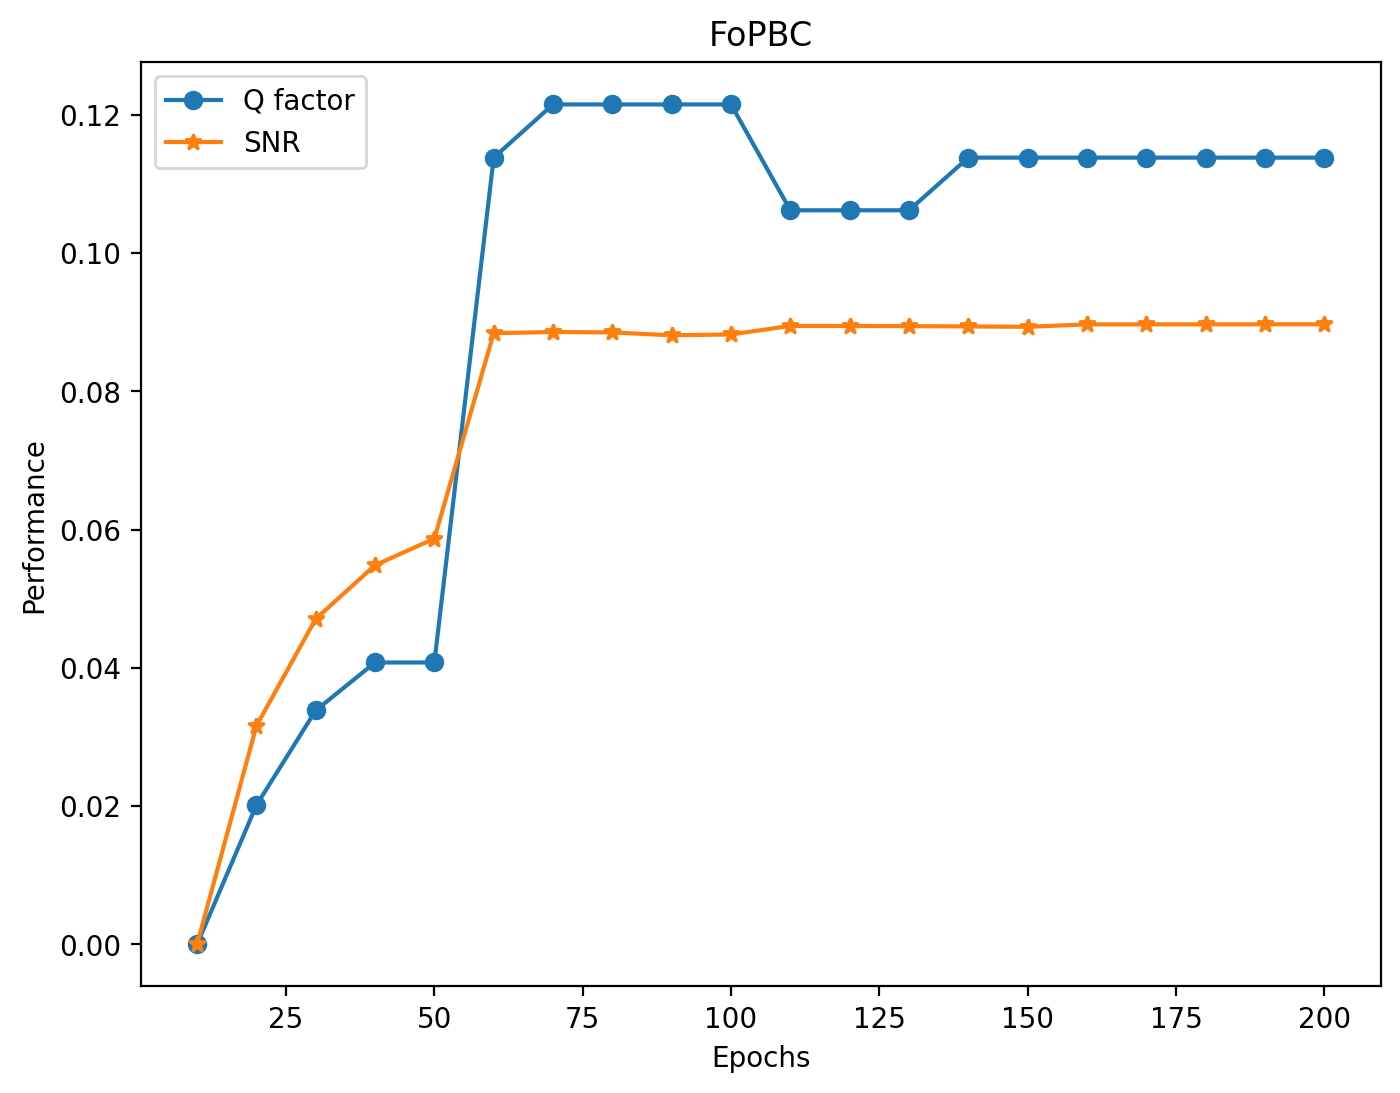

In [6]:
import torch, matplotlib.pyplot as plt, numpy as np

Q  = []
SNR = []
epochs = range(10, 210, 10)
for i in epochs:
    ckpt1 = torch.load(f'_models/up_scale_Rs40_Nch1_Pch-2/FoPBC_new.ckpt{i}', map_location='cpu')
    Q.append(ckpt1['metric']['Qsq'][6])
    SNR.append(ckpt1['metric']['SNR'][6])
Q = np.array(Q)
SNR = np.array(SNR)


plt.figure(figsize=(8,6), dpi=200)
plt.plot(epochs, Q - np.min(Q), '-o', label='Q factor')
plt.plot(epochs, SNR - np.min(SNR), '-*', label='SNR')
plt.xlabel('Epochs')
plt.ylabel('Performance')
plt.title('FoPBC')
plt.legend()

In [ ]:
# 1.选择一个更合适的损失函数
# 2.选择合理的训练策略，比如先训练第一层，固定住后训练第二层
# 3. more data

In [14]:
import pickle , matplotlib.pyplot as plt, torch, numpy as np, argparse, time, os, scipy
from src.TorchDSP.pbc_new import NonlienarFeatures, FoPBC
from src.TorchDSP.dataloader import  get_signals
from src.TorchSimulation.receiver import  BER

path =  "data/test_data_afterCDCDSP.pkl"
signal, truth, z = get_signals(path, Nch=1, Rs=40, Pch=[-2],  device='cpu')

Text(0.5, 1.0, 'loss function')

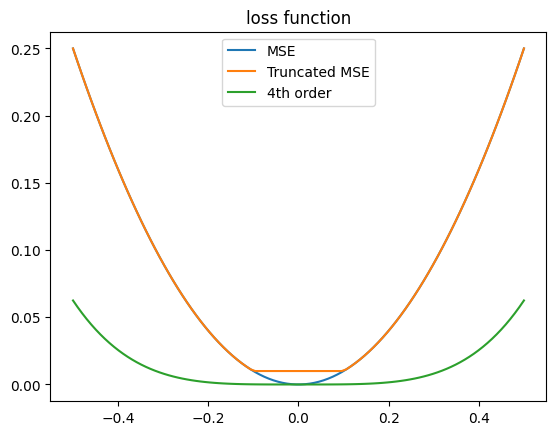

In [27]:
import torch 


x = torch.linspace(-0.5, 0.5, 100)
y1 = x**2 
y2 = torch.max(torch.tensor(0.1), torch.abs(x))**2
y3 = x**4 

plt.plot(x, y1, label='MSE')
plt.plot(x, y2, label='Truncated MSE')
plt.plot(x, y3, label='4th order')
plt.legend()
plt.title('loss function')

# Scatter plot

In [1]:
import pickle , matplotlib.pyplot as plt, torch, numpy as np, argparse, time, os, scipy
from src.TorchDSP.pbc_new import NonlienarFeatures, FoPBC
from src.TorchDSP.dataloader import  get_signals
from src.TorchSimulation.receiver import  BER
from src.TorchDSP.train_pbc import test_model
from src.JaxSimulation.utils import show_symb

path =  "data/test_data_afterCDCDSP.pkl"
signal, truth, z = get_signals(path, Nch=1, Rs=40, Pch=[-2],  device='cpu')

/home/xiaoxinyu/.conda/envs/fiber/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [57]:
ckpt2 = torch.load(f'_models/up_scale_Rs40_Nch1_Pch-2/AmFoPBC.ckpt200', map_location='cpu')
y,x = test_model(ckpt2,  signal, truth, z, device='cpu')  
x = x.numpy()
y = y.numpy()

Testing: 
Time cost: 18.030734539031982


In [ ]:
# Rx -  D(Rx)

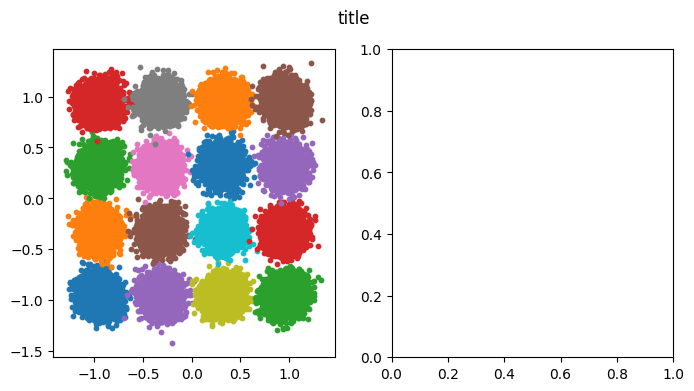

In [60]:
show_symb(y[0, 10000:80000], x[0, 10000:80000])

In [61]:
ckpt1 = torch.load(f'_models/up_scale_Rs40_Nch1_Pch-2/MultiStep.ckpt200', map_location='cpu')

y1,x1 = test_model(ckpt1,  signal, truth, z, device='cpu')

x1 = x1.numpy()
y1 = y1.numpy()

Testing: 
Time cost: 36.25349402427673


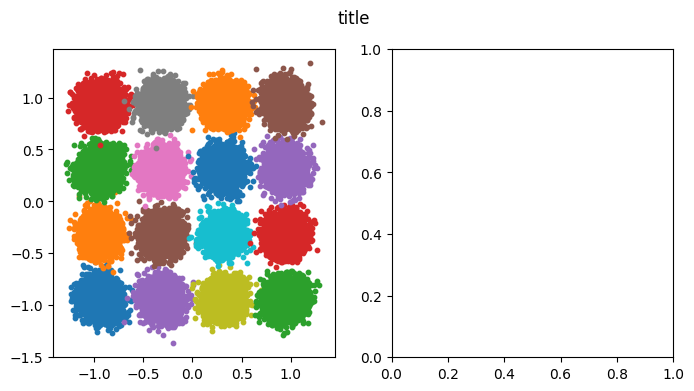

In [62]:
show_symb(y1[0, 10000:80000], x1[0, 10000:80000])

# Find best p

Text(0.5, 1.0, 'w = 0, data size=70000')

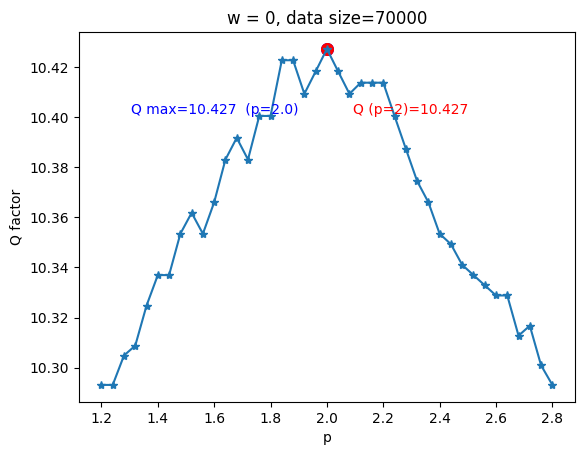

In [1]:
import pickle, numpy as np, matplotlib.pyplot as plt

res = pickle.load(open('res_p_Tr[-2]_Te[-2]_iter1.pkl', 'rb'))
Q = [np.squeeze(q) for q in res['Q']]
p = res['p']
plt.plot(p, Q, '-*')
plt.xlabel('p')
plt.ylabel('Q factor')

plt.text(1.9, 10.4, f'Q max={np.max(Q):.3f}  (p={p[np.argmax(Q)]:.1f})', ha='right', va='bottom', color='b')
plt.scatter(p[np.argmax(Q)], np.max(Q), color='b', s=70)

plt.text(2.5, 10.4, f'Q (p=2)={Q[20]:.3f}', ha='right', va='bottom', color='r')
plt.scatter(p[20], Q[20], color='r', s=70)

plt.title(f'w = 0, data size={res["n"] * 7}')


# CDC, DBP results

In [ ]:
# from src.TorchDSP.dataloader import get_k, get_k_batch
# res, code = pickle.load(open('_outputs/Qfactor/Nmodes2/CDC.pkl','rb'))
# P = np.arange(-8, 9)
# Rs = 80
# s = 1

# k = get_k_batch(1, Rs, code)
# Q = res['BER from 10000th symb']['CDC']['Qsq'][k][:,s]
# # Q = np.mean(Q, axis=1)
# plt.plot(P, Q)

# k = get_k_batch(3, Rs, code)
# Q = res['BER from 10000th symb']['CDC']['Qsq'][k][:,s]
# # Q = np.mean(Q, axis=1)
# plt.plot(P, Q)

# k = get_k_batch(5, Rs, code)
# Q = res['BER from 10000th symb']['CDC']['Qsq'][k][:,s]
# # Q = np.mean(Q, axis=1) 
# plt.plot(P, Q)

# plt.ylim(6, 10)

# CDC vs PBC

In [115]:
from test import *

# train_path = "data/lab/train_Rs36G_Nch7_Pch0.pkl"
# test_path = "data/lab/test_Rs36G_Nch7_Pch0.pkl"


path = "data/lab/test_2_0_4_1.pkl"
Nmodes = 2
Nch = 7
Rs = 36
train_path = path 
test_path = path
idx1 = (100000, 200000)
idx2 = (200000, 300000)


# train_path = "data/Nmodes2/train_afterCDCDSP.pkl"
# test_path = "data/Nmodes2/test_afterCDCDSP.pkl"
# Nmodes = 2
# Nch = 5 
# Rs = 40
# idx1 = (10000, -10000)
# idx2 = (10000, -10000)

rho = 1
L = 200
index_type = 'reduce-1'
train_p = [0]
test_p = [0]
lamb_l2 = 0

index = NonlienarFeatures(Nmodes=Nmodes, rho=rho, L = L, index_type=index_type).index
train_data = trainsfrom_signal(train_path, rho=rho, L=L, Nch=Nch, Rs=Rs, Pch=train_p, index_type=index_type, idx=idx1)
test_data = trainsfrom_signal(test_path, rho=rho, L=L, Nch=Nch, Rs=Rs, Pch=test_p, index_type=index_type, idx=idx2)

In [116]:
s, e = 1000, -1000
use_Rx_only = True
P, X0, X1, Y_real, Symb = train_data
Y = nearst_symb(X0) - X0 if use_Rx_only else Y_real
C0 =  fit(P, X1[:,s:e,:,:], Y[:,s:e,:], lamb_l2=lamb_l2, pol_sep=True)

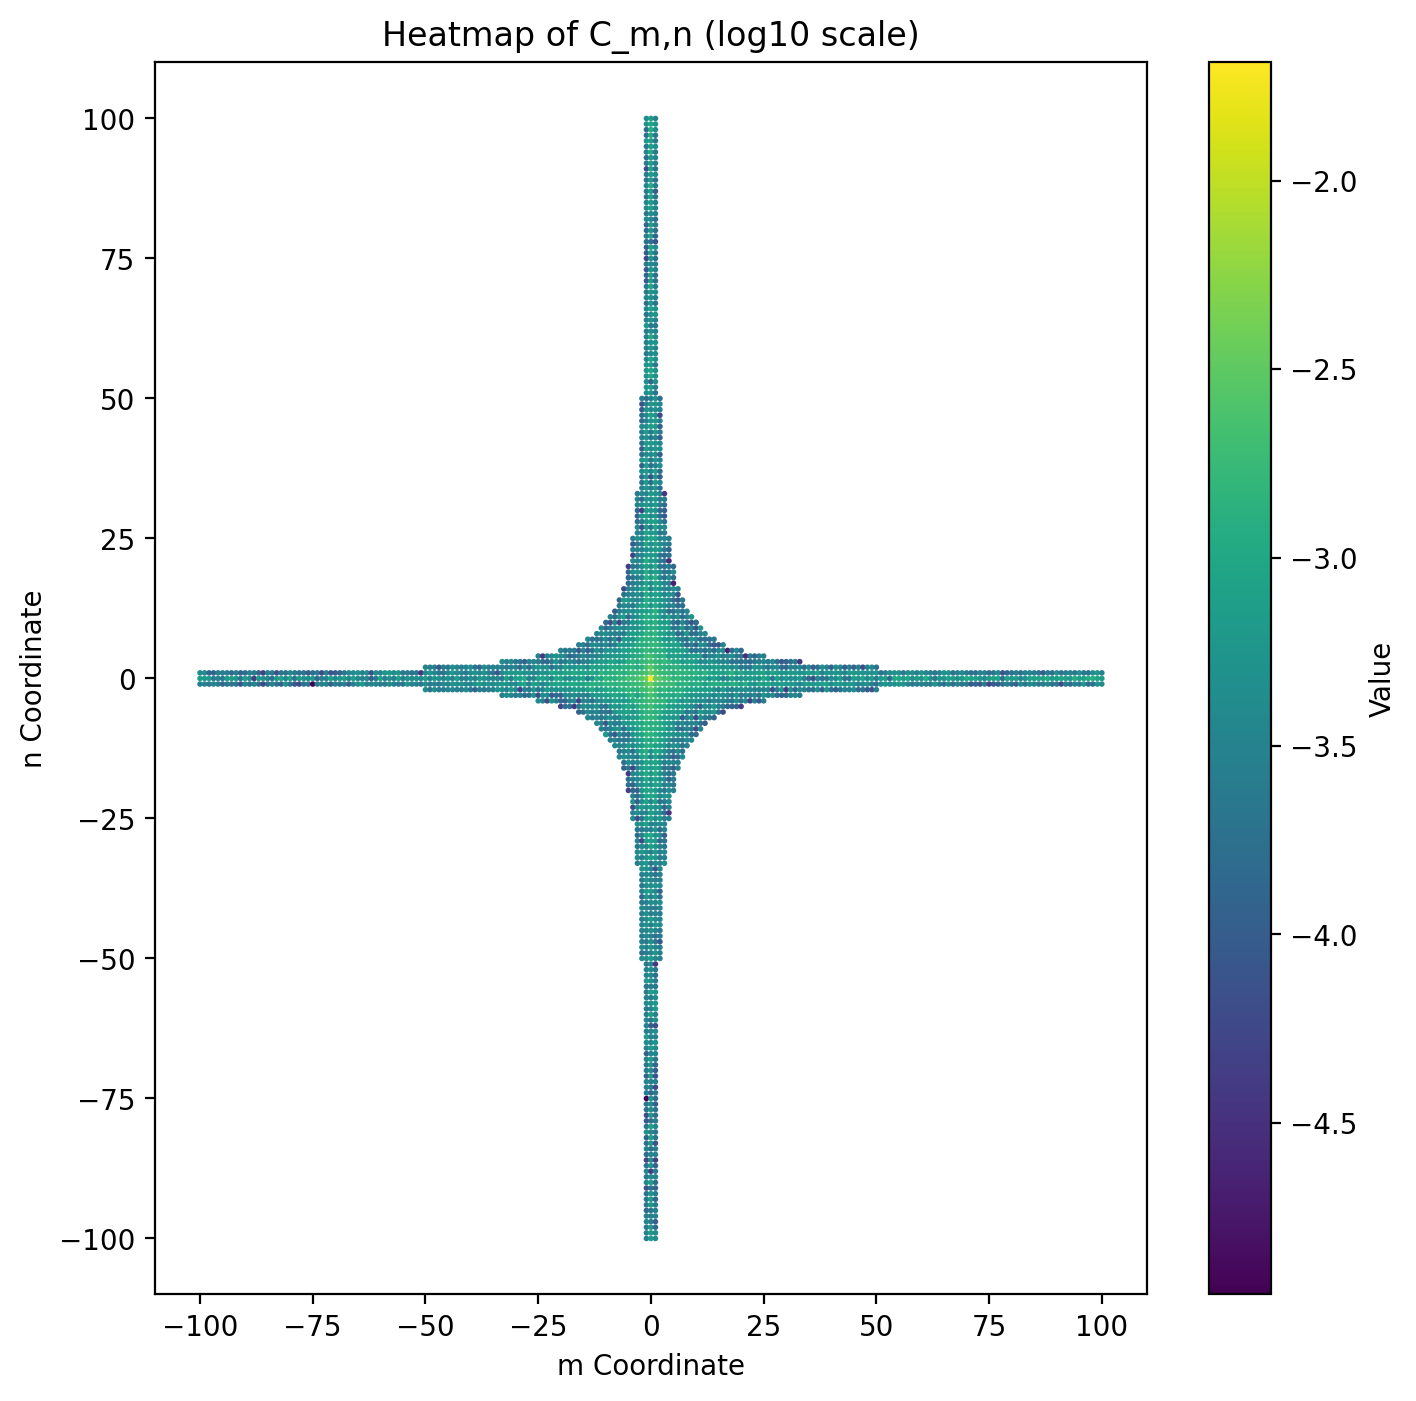

In [117]:
show_pbc(C0[0], index, vmax=None, vmin=None, figsize=(8,8),dpi=200, s=1) # type: ignore

In [149]:
Qpbc = test(test_data, C0, xis=np.linspace(1,1,1), BER_discard=200)[1]
Qcdc = BER(test_data[1], test_data[4])

print('CDC mean Qsq (dB):', np.mean(Qcdc['Qsq']))
print('PBC mean Qsq (dB):', np.mean(Qpbc))
print('diff:             ', np.mean(Qpbc) - np.mean(Qcdc['Qsq']))

CDC mean Qsq (dB): 8.2323475
PBC mean Qsq (dB): 8.567471
diff:              0.33512306


# Error normal test

In [123]:
def normal(Y1):
    error1 = (Y1.real - torch.mean(Y1.real)) / torch.std(Y1.real)
    error2 = (Y1.imag - torch.mean(Y1.imag)) / torch.std(Y1.imag)
    error = torch.stack([error1.flatten(), error2.flatten()], dim=1)
    return error

In [124]:
P, X0, X1, Y, Symb = test_data
pbc = predict(P, X1, C0)  # pbc

In [125]:
BER(X0 + pbc, Symb)

{'BER': array([[0.00250503, 0.00518755]], dtype=float32),
 'SER': array([[0.0099801 , 0.02065021]], dtype=float32),
 'Qsq': array([[8.962951, 8.17521 ]], dtype=float32),
 'SNR': array([[15.972548, 15.139826]], dtype=float32)}

In [126]:
BER(X0, Symb)

{'BER': array([[0.00383754, 0.00626756]], dtype=float32),
 'SER': array([[0.01527015, 0.02494025]], dtype=float32),
 'Qsq': array([[8.51733 , 7.947364]], dtype=float32),
 'SNR': array([[15.38851 , 14.684688]], dtype=float32)}

In [129]:
torch.std(Symb - X0)

tensor(0.1775)

In [131]:
torch.std(Symb - X0 - pbc)

tensor(0.1673)

In [132]:
torch.std(pbc)

tensor(0.0582)

In [134]:
error = normal(Y)
print('covariance matrix of error:')
torch.cov(error.T)

covariance matrix of error:


tensor([[ 1.0000, -0.0033],
        [-0.0033,  1.0000]])

Text(0.5, 1.0, 'Error distribution of the testing data (error = Rx - Tx - PBC)')

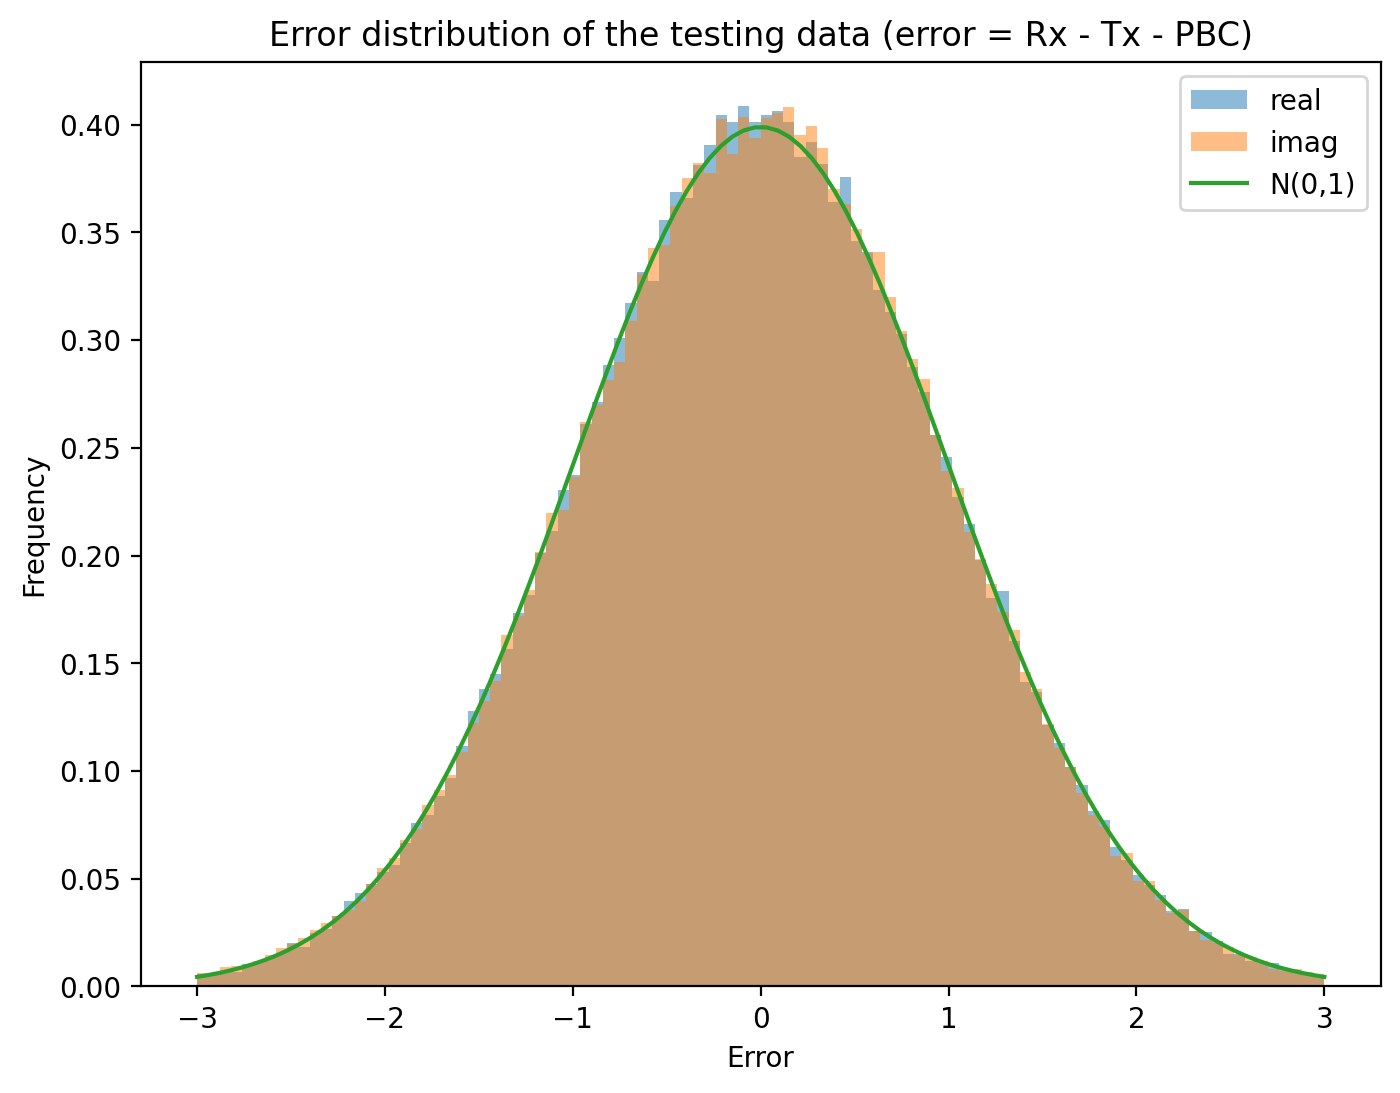

In [141]:
# histogram of pbc
error = normal(Symb - X0 - pbc)
x_range=(-3, 3)
plt.figure(figsize=(8,6), dpi=200)
plt.hist(error[:,0], bins=100, range=x_range, density=True, alpha=0.5, label='real')
plt.hist(error[:,1], bins=100, range=x_range, density=True, alpha=0.5, label='imag')

# plot N(0,1) pdf
x = np.linspace(*x_range, 100)
y = np.exp(-x**2/2) / np.sqrt(2*np.pi)
plt.plot(x, y, label='N(0,1)')

plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Error distribution of the testing data (error = Rx - Tx - PBC)')

Text(0.5, 1.0, 'distribution of the PBC term')

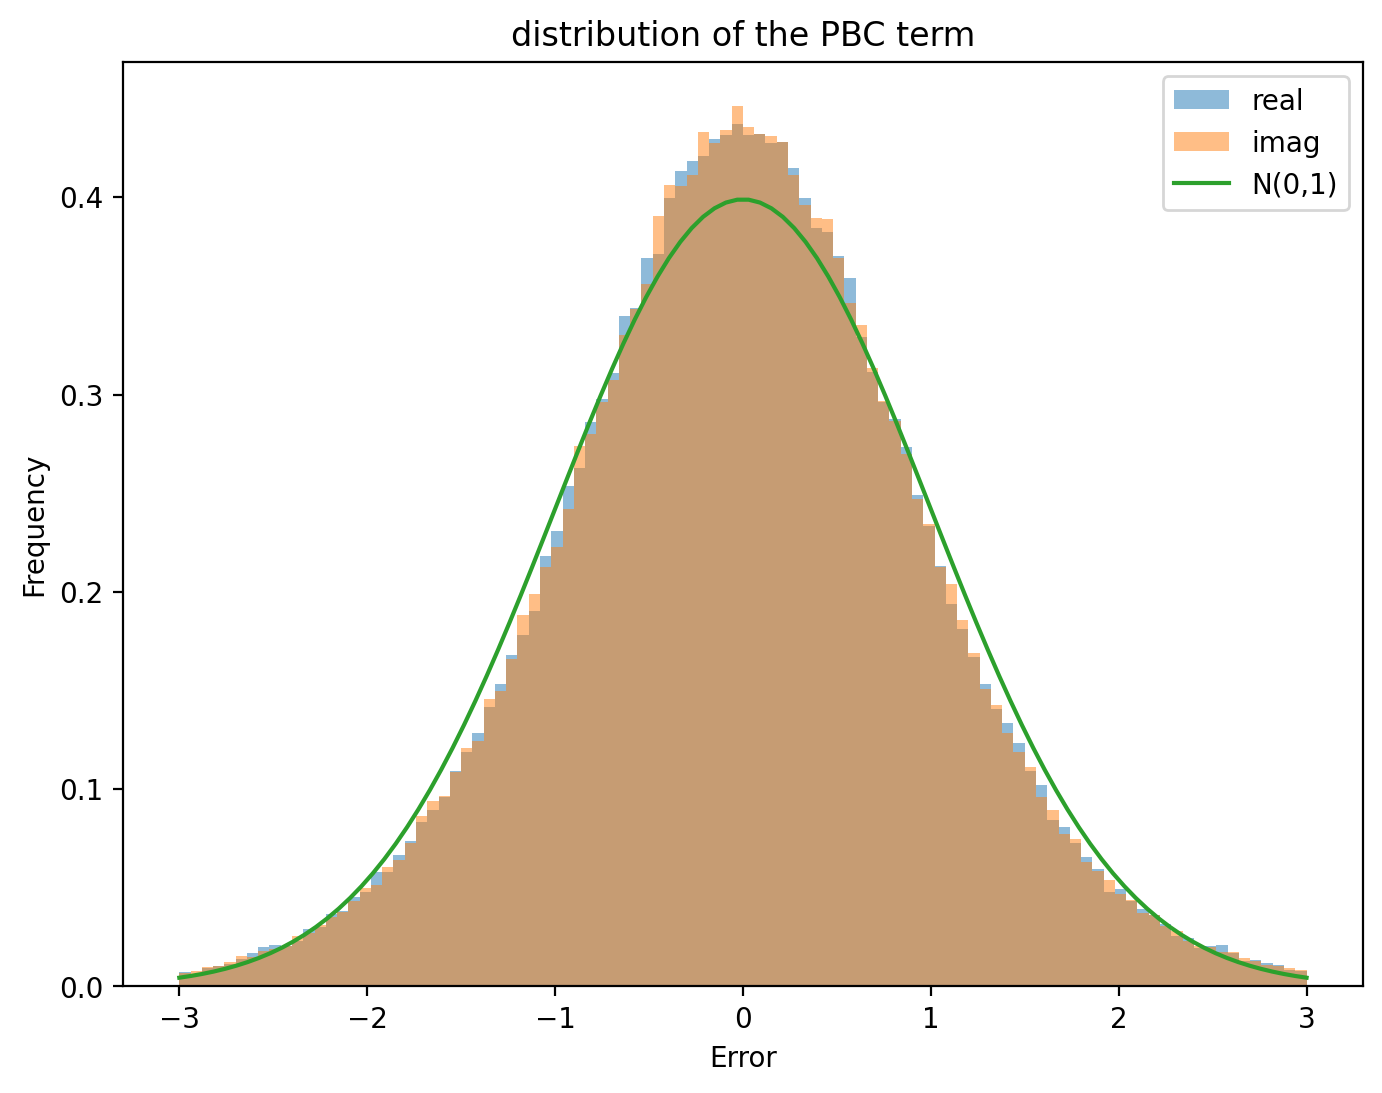

In [140]:
# histogram of pbc
error = normal(pbc)
x_range=(-3, 3)
plt.figure(figsize=(8,6), dpi=200)
plt.hist(error[:,0], bins=100, range=x_range, density=True, alpha=0.5, label='real')
plt.hist(error[:,1], bins=100, range=x_range, density=True, alpha=0.5, label='imag')

# plot N(0,1) pdf
x = np.linspace(*x_range, 100)
y = np.exp(-x**2/2) / np.sqrt(2*np.pi)
plt.plot(x, y, label='N(0,1)')

plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('distribution of the PBC term')

Text(0.5, 1.0, 'Error distribution of the testing data (error = Rx - Tx)')

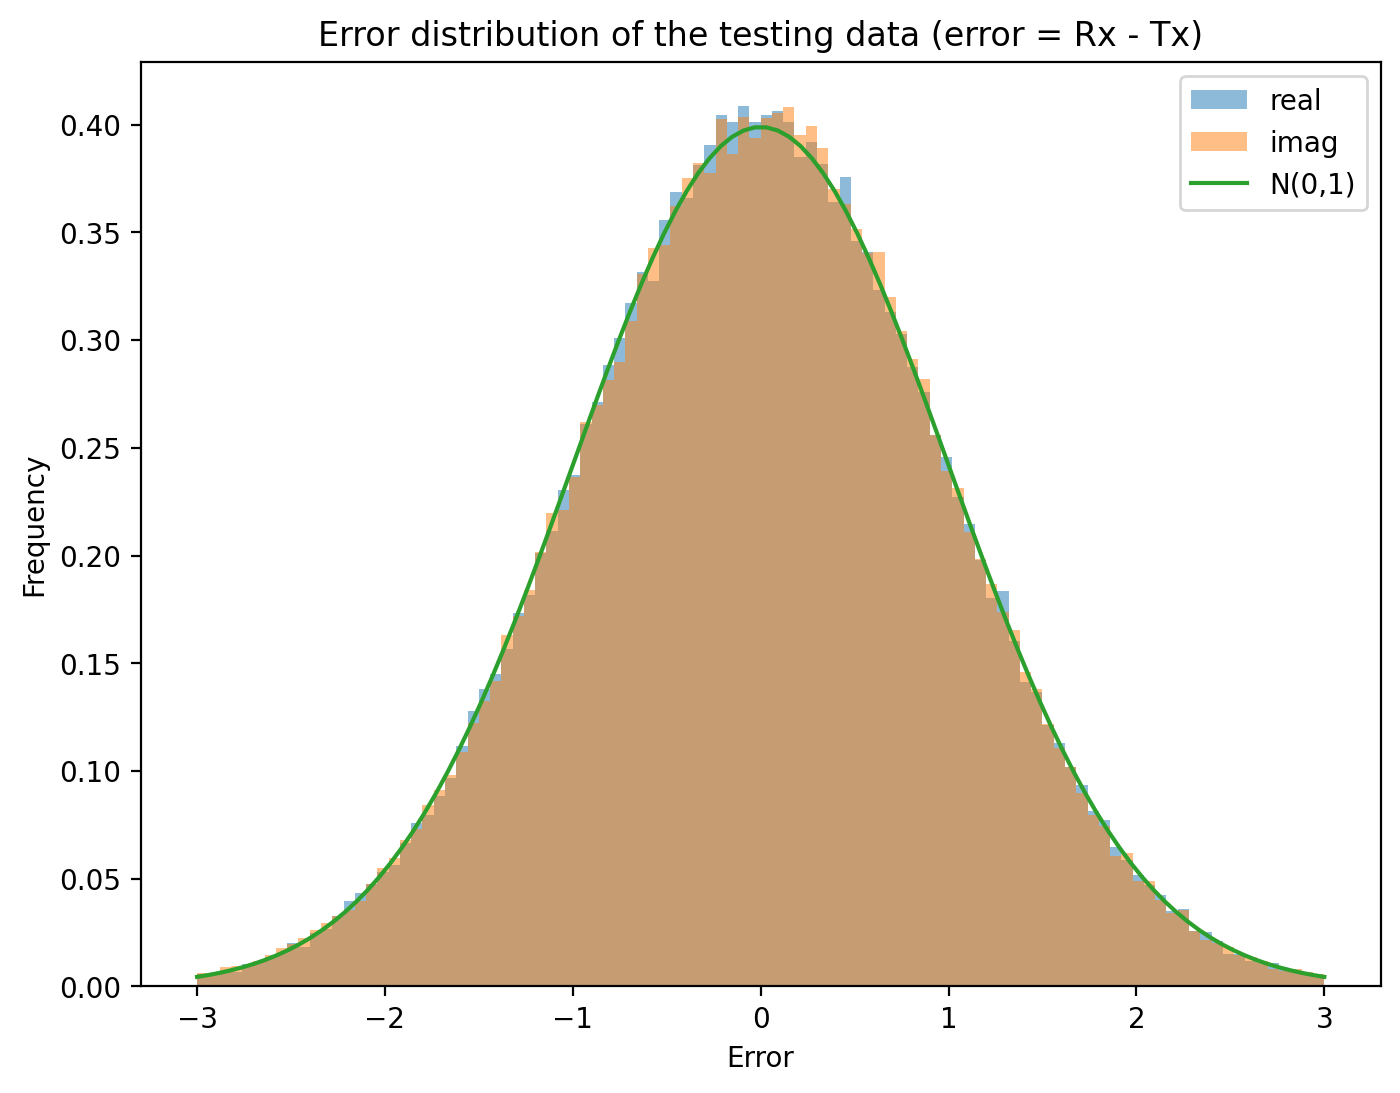

In [74]:
# histogram of error
plt.figure(figsize=(8,6), dpi=200)
plt.hist(error[:,0], bins=100, range=(-3, 3), density=True, alpha=0.5, label='real')
plt.hist(error[:,1], bins=100, range=(-3, 3), density=True, alpha=0.5, label='imag')

# plot N(0,1) pdf

x = np.linspace(-3, 3, 100)
y = np.exp(-x**2/2) / np.sqrt(2*np.pi)
plt.plot(x, y, label='N(0,1)')

plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Error distribution of the testing data (error = Rx - Tx)')

Shapiro-Wilk test results for each dimension:
[ShapiroResult(statistic=0.9994813203811646, pvalue=0.35687485337257385), ShapiroResult(statistic=0.999432384967804, pvalue=0.2736441195011139)]
Log-likelihood statistics:
Mean: -2.9580116083920873, Std: 1.0220296080105744


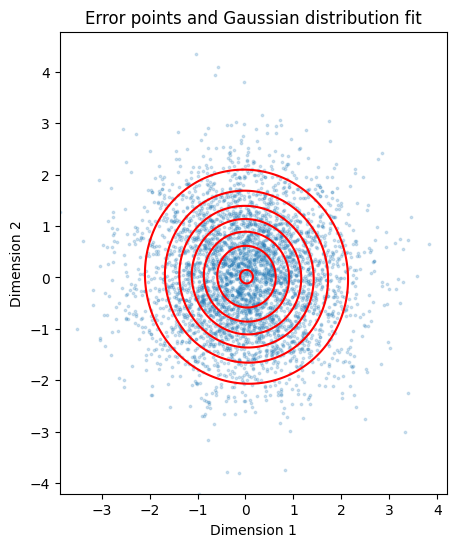

In [23]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import shapiro

# 假设data是一个形状为[N, 2]的numpy数组
# data = np.random.randn(300000, 2)  # 这里仅作为示例，您应替换为您的数据
data = error.numpy()[0:4000]

# 检查每个维度的正态性
shapiro_results = [shapiro(data[:, i]) for i in range(2)]
print("Shapiro-Wilk test results for each dimension:")
print(shapiro_results)

# 如果数据维度大，Shapiro-Wilk 测试可能不适用，此时考虑使用可视化方法
# 计算样本均值和协方差矩阵，用于定义多变量正态分布
mean = np.mean(data, axis=0)
cov = np.cov(data, rowvar=False)

# 使用多变量高斯分布模型拟合数据，计算对数似然
model = multivariate_normal(mean=mean, cov=cov)
log_likelihood = model.logpdf(data)

# 输出对数似然值的统计信息
print("Log-likelihood statistics:")
print(f"Mean: {np.mean(log_likelihood)}, Std: {np.std(log_likelihood)}")

# 可视化结果，比如绘制数据的散点图和多变量高斯分布的等高线
import matplotlib.pyplot as plt

# 绘制数据点
plt.figure(figsize=(5,6),dpi=100)
plt.scatter(data[:, 0], data[:, 1], s=3,  alpha=0.2)
# 绘制高斯分布的等高线
x, y = np.mgrid[min(data[:,0]):max(data[:,0]):.01, min(data[:,1]):max(data[:,1]):.01]
pos = np.dstack((x, y))
plt.contour(x, y, model.pdf(pos), colors='r')

plt.title('Error points and Gaussian distribution fit')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


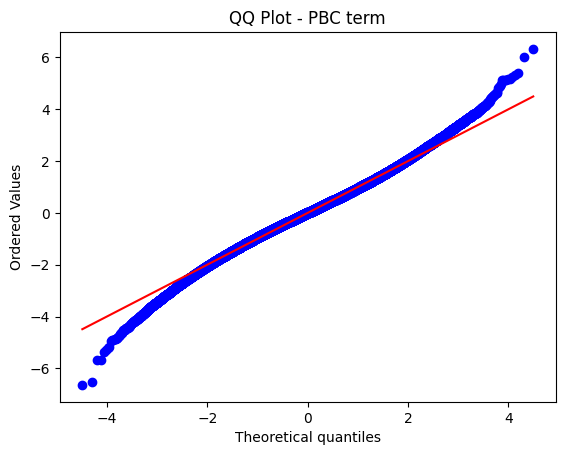

In [144]:
import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt 

# 假设data是一个包含50000个点的numpy数组，这里使用正态分布随机生成数据作为示例
error = normal(pbc)
data = error[:,1]  # 替换为您的数据

# 生成QQ图
stats.probplot(data, dist="norm", plot=plt)
plt.title('QQ Plot - PBC term')
plt.show()


/tmp/ipykernel_18529/1706251197.py:16: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(len(lag_acf)), lag_acf, use_line_collection=True)


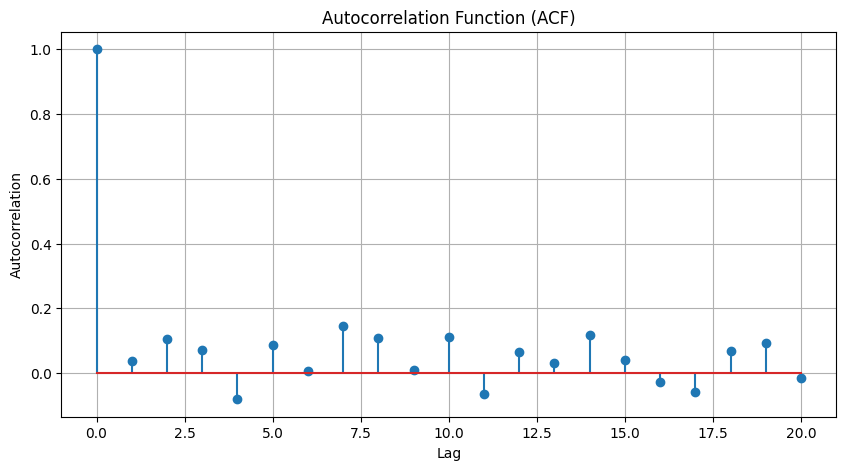

1

In [187]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# 假设 sequence 是你的数据序列，这里我们生成一个示例序列
np.random.seed(0)

sequence = np.random.randn(200)
# sequence = error[0:200,0]

# 计算自相关函数（ACF）
lag_acf = acf(sequence, nlags=20)

# 绘制ACF
plt.figure(figsize=(10, 5))
plt.stem(range(len(lag_acf)), lag_acf, use_line_collection=True)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()

# 确定记忆关联长度
# 通常选择自相关值首次穿越零点或下降到某个阈值以下作为关联长度
threshold = 0.2  # 这个阈值可以根据具体情况调整
memory_length = np.where(lag_acf < threshold)[0][0] if np.any(lag_acf < threshold) else None

memory_length


# Test new loss function

In [26]:
from test import *
from src.TorchDSP.train_nn import Qsq
# train_path = "data/lab/train_Rs36G_Nch7_Pch0.pkl"
# test_path = "data/lab/test_Rs36G_Nch7_Pch0.pkl"


path = "data/lab/test_2_0_4_1.pkl"
Nmodes = 2
Nch = 7
Rs = 36
train_path = path 
test_path = path
idx1 = (1000000, 1100000)
idx2 = (110000, 1200000)


# train_path = "data/Nmodes2/train_afterCDCDSP.pkl"
# test_path = "data/Nmodes2/test_afterCDCDSP.pkl"
# Nmodes = 2
# Nch = 5 
# Rs = 40
# idx1 = (10000, -10000)
# idx2 = (10000, -10000)

rho = 1
L = 300
index_type = 'reduce-1'
train_p = [0]
test_p = [0]
lamb_l2 = 0

index = NonlienarFeatures(Nmodes=Nmodes, rho=rho, L = L, index_type=index_type).index
train_data = trainsfrom_signal(train_path, rho=rho, L=L, Nch=Nch, Rs=Rs, Pch=train_p, index_type=index_type, idx=idx1)
test_data = trainsfrom_signal(test_path, rho=rho, L=L, Nch=Nch, Rs=Rs, Pch=test_p, index_type=index_type, idx=idx2)

EOFError: Ran out of input

In [11]:
s, e = 1000, -1000
use_Rx_only = False
P, X0, X1, Y_real, Symb = train_data
Y = nearst_symb(X0) - X0 if use_Rx_only else Y_real
C0 =  fit(P, X1[:,s:e,:,:], Y[:,s:e,:], lamb_l2=lamb_l2, pol_sep=True)

In [22]:
metric = test(test_data, C0, BER_discard=200)

In [25]:
Qsq(np.mean(metric['BER']))

8.55848925084559

我的形式：
$$
weight(x) = \|Decision(x) - x\|^{p-2} \cdot min\{1, \frac{\gamma}{\|Decision(x) - x\|}\}^2
$$
你们的形式：
$$
weight(x) = \|Decision(x) - x\|^{\frac{p-2}{2}} \cdot min\{1, \frac{\gamma}{\|Decision(x) - x\|}\}
$$

In [4]:
np.mean(test(test_data, C0, xis=np.linspace(1,1,1), BER_discard=200)[1])

8.629398

In [230]:
ps = np.linspace(1, 3, 11)
gammas = np.linspace(0.1, 2, 20)
Q_list = {}
L_list = {}


for p in ps:
    for gamma in gammas:
        t0 = time.time()
        weight = Kernel(P, X1[:,s:e,:,:], Y[:,s:e,:], C0, p=1, gamma=torch.std(Y).item()*gamma, k_type='tc') * Kernel(P, X1[:,s:e,:,:], Y[:,s:e,:], C0, p=p, k_type='w=0') 
        C = fit(P, X1[:,s:e,:,:], Y[:,s:e,:], weight, lamb_l2=lamb_l2, pol_sep=False)  # [Nmodes, p]
        L1, Q1 = test(test_data,C, xis=np.linspace(1,1,1), BER_discard=200)
        t1 = time.time()
        print(f'p={p}, gamma={gamma}, time: {t1-t0}, Q1={Q1}, MSE={L1}')
        Q_list[f'p={p}, gamma={gamma}'] = Q1
        L_list[f'p={p}, gamma={gamma}'] = L1


p=1.0, gamma=0.1, time: 8.502718687057495, Q1=[[[8.666496 8.055898]]], MSE=[[[0.02758632 0.03269788]]]
p=1.0, gamma=0.2, time: 8.133132219314575, Q1=[[[8.701965 8.083535]]], MSE=[[[0.02734169 0.03245677]]]
p=1.0, gamma=0.3, time: 8.50885796546936, Q1=[[[8.731693 8.100784]]], MSE=[[[0.02713047 0.03224908]]]
p=1.0, gamma=0.4, time: 8.183969974517822, Q1=[[[8.752731 8.116578]]], MSE=[[[0.02694828 0.03207049]]]
p=1.0, gamma=0.5, time: 9.252517938613892, Q1=[[[8.770662 8.126461]]], MSE=[[[0.02679043 0.03191644]]]
p=1.0, gamma=0.6, time: 8.433960199356079, Q1=[[[8.780151 8.139181]]], MSE=[[[0.02665443 0.03178317]]]
p=1.0, gamma=0.7, time: 8.411294937133789, Q1=[[[8.794079 8.145858]]], MSE=[[[0.02653944 0.03167022]]]
p=1.0, gamma=0.7999999999999999, time: 8.526882886886597, Q1=[[[8.807269 8.152563]]], MSE=[[[0.02644241 0.03157487]]]
p=1.0, gamma=0.8999999999999999, time: 8.581517219543457, Q1=[[[8.812582 8.153124]]], MSE=[[[0.02636183 0.03149557]]]
p=1.0, gamma=0.9999999999999999, time: 9.081

Text(0.5, 0, 'Q')

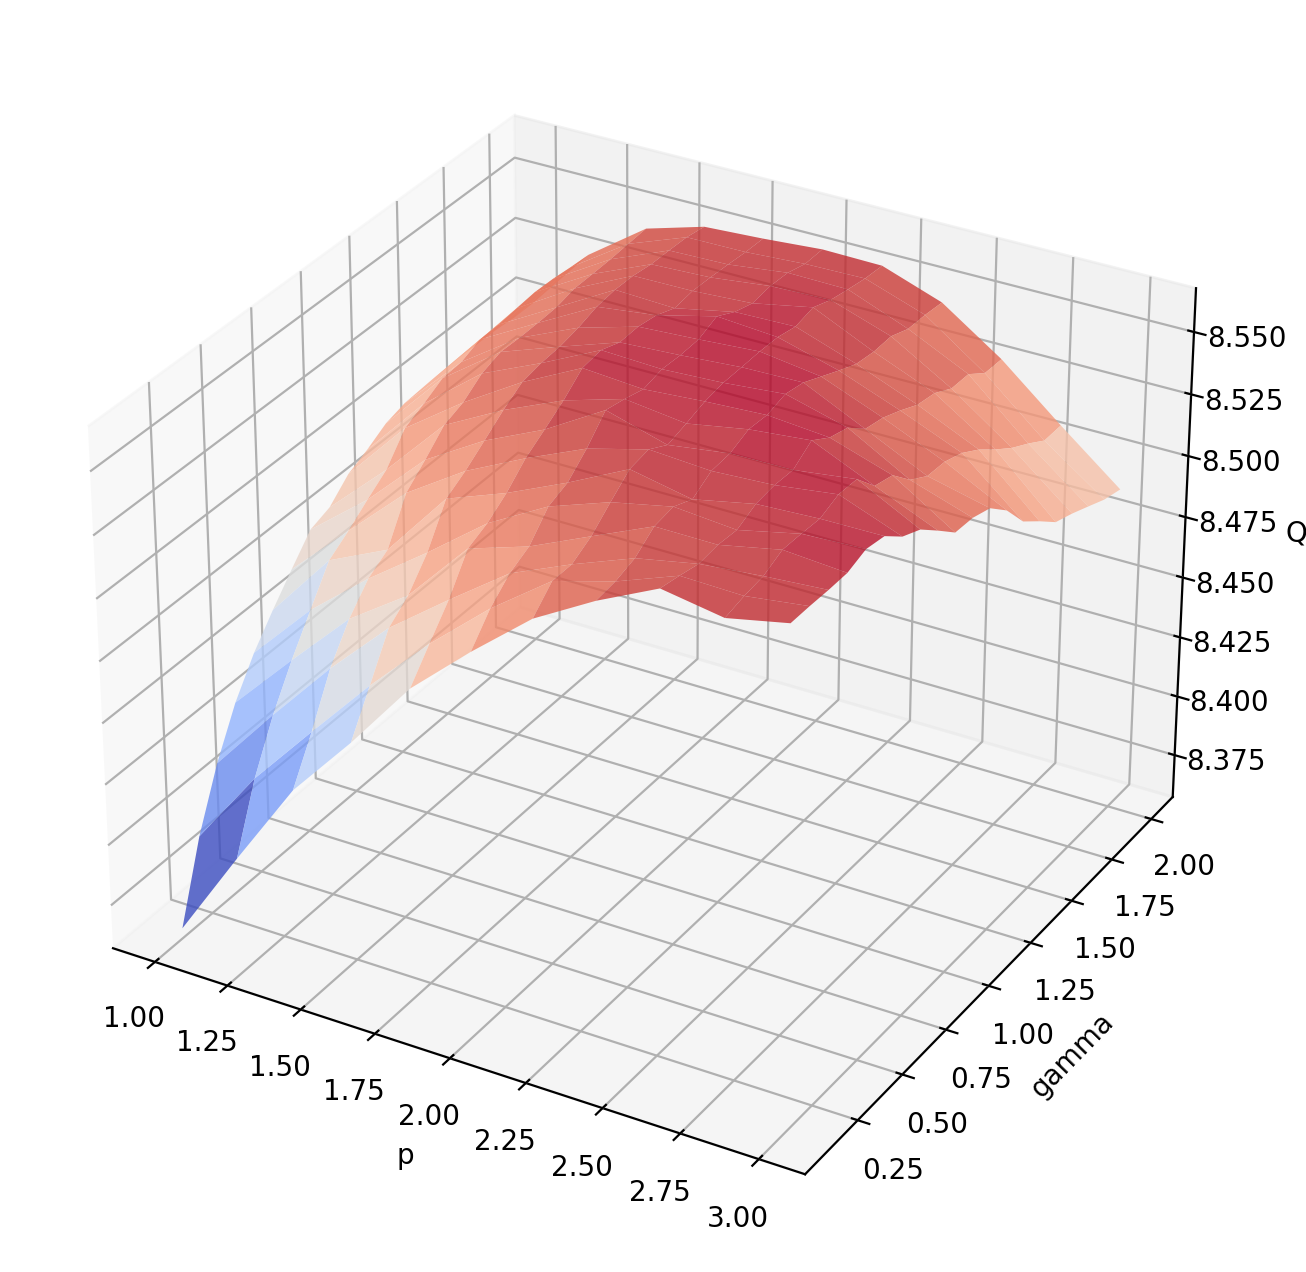

In [231]:
# 2d plot, X axis is p, Y axis is gamma, Z axis is Q
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

fig = plt.figure(figsize=(10,8), dpi=200)
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(ps, gammas)
Z = np.array([np.mean(Q_list[f'p={p}, gamma={gamma}']) for p, gamma in zip(X.flatten(), Y.flatten())]).reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha=0.8)
ax.set_xlabel('p')
ax.set_ylabel('gamma')
ax.set_zlabel('Q')

In [241]:
Q_list

{'p=1.0, gamma=0.1': array([[[8.666496, 8.055898]]], dtype=float32),
 'p=1.0, gamma=0.2': array([[[8.701965, 8.083535]]], dtype=float32),
 'p=1.0, gamma=0.3': array([[[8.731693, 8.100784]]], dtype=float32),
 'p=1.0, gamma=0.4': array([[[8.752731, 8.116578]]], dtype=float32),
 'p=1.0, gamma=0.5': array([[[8.770662, 8.126461]]], dtype=float32),
 'p=1.0, gamma=0.6': array([[[8.780151, 8.139181]]], dtype=float32),
 'p=1.0, gamma=0.7': array([[[8.794079, 8.145858]]], dtype=float32),
 'p=1.0, gamma=0.7999999999999999': array([[[8.807269, 8.152563]]], dtype=float32),
 'p=1.0, gamma=0.8999999999999999': array([[[8.812582, 8.153124]]], dtype=float32),
 'p=1.0, gamma=0.9999999999999999': array([[[8.824168, 8.156488]]], dtype=float32),
 'p=1.0, gamma=1.0999999999999999': array([[[8.826858, 8.161549]]], dtype=float32),
 'p=1.0, gamma=1.2': array([[[8.829552, 8.168323]]], dtype=float32),
 'p=1.0, gamma=1.3': array([[[8.835859, 8.166627]]], dtype=float32),
 'p=1.0, gamma=1.4': array([[[8.834955, 8.1

In [222]:
plt.plot(gammas, [np.mean(Q_list[f'p=1.0, gamma={gamma}']) for gamma in gammas], '-o', label='p=1.0')
plt.plot(gammas, [np.mean(Q_list[f'p=2.0, gamma={gamma}']) for gamma in gammas], '-o', label='p=2.0')
plt.plot(gammas, [np.mean(Q_list[f'p=3.0, gamma={gamma}']) for gamma in gammas], '-o', label='p=3.0')
plt.xlabel('gamma')
plt.ylabel('Q factor')
plt.legend()

KeyError: 'p=1.0, gamma=0.1'

Text(0.5, 1.0, 'Qirui Fan lab data')

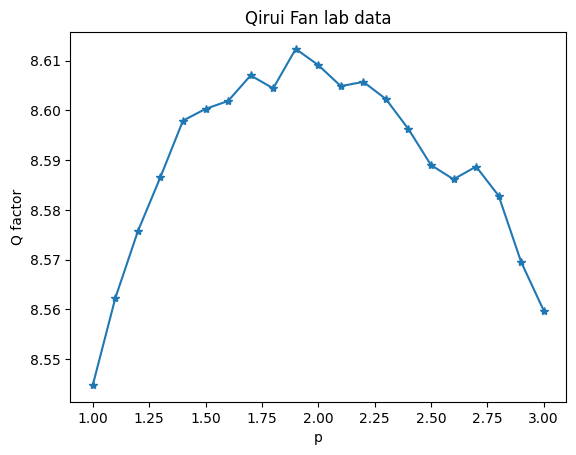

In [173]:
plt.plot(ps,[np.mean(q) for q in Q_list], '-*')
plt.xlabel('p')
plt.ylabel('Q factor')
plt.title('Qirui Fan lab data')

In [ ]:
import pickle, numpy as np, matplotlib.pyplot as plt

res = pickle.load(open('res_0318.pkl', 'rb'))
Q = [np.squeeze(q) for q in res['Q']]
p = res['p']
plt.plot(p, Q, '-*')
plt.xlabel('p')
plt.ylabel('Q factor')

# plt.text(1.9, 10.4, f'Q max={np.max(Q):.3f}  (p={p[np.argmax(Q)]:.1f})', ha='right', va='bottom', color='b')
# plt.scatter(p[np.argmax(Q)], np.max(Q), color='b', s=70)

# plt.text(2.5, 10.4, f'Q (p=2)={Q[20]:.3f}', ha='right', va='bottom', color='r')
# plt.scatter(p[20], Q[20], color='r', s=70)

plt.title(f'w = 0, data size={res["n"]}')


In [39]:
import pickle, numpy as np, matplotlib.pyplot as plt

Q, L = pickle.load(open('res_p_gamma.pkl', 'rb'))

In [51]:
ps[gamma_max], gammas[p_max], Q_max

(2.4000000000000004, 1.2, 8.571251)

Text(2.4000000000000004, 1.2, 'Q max=8.571  p=2.4, gamma=1.2')

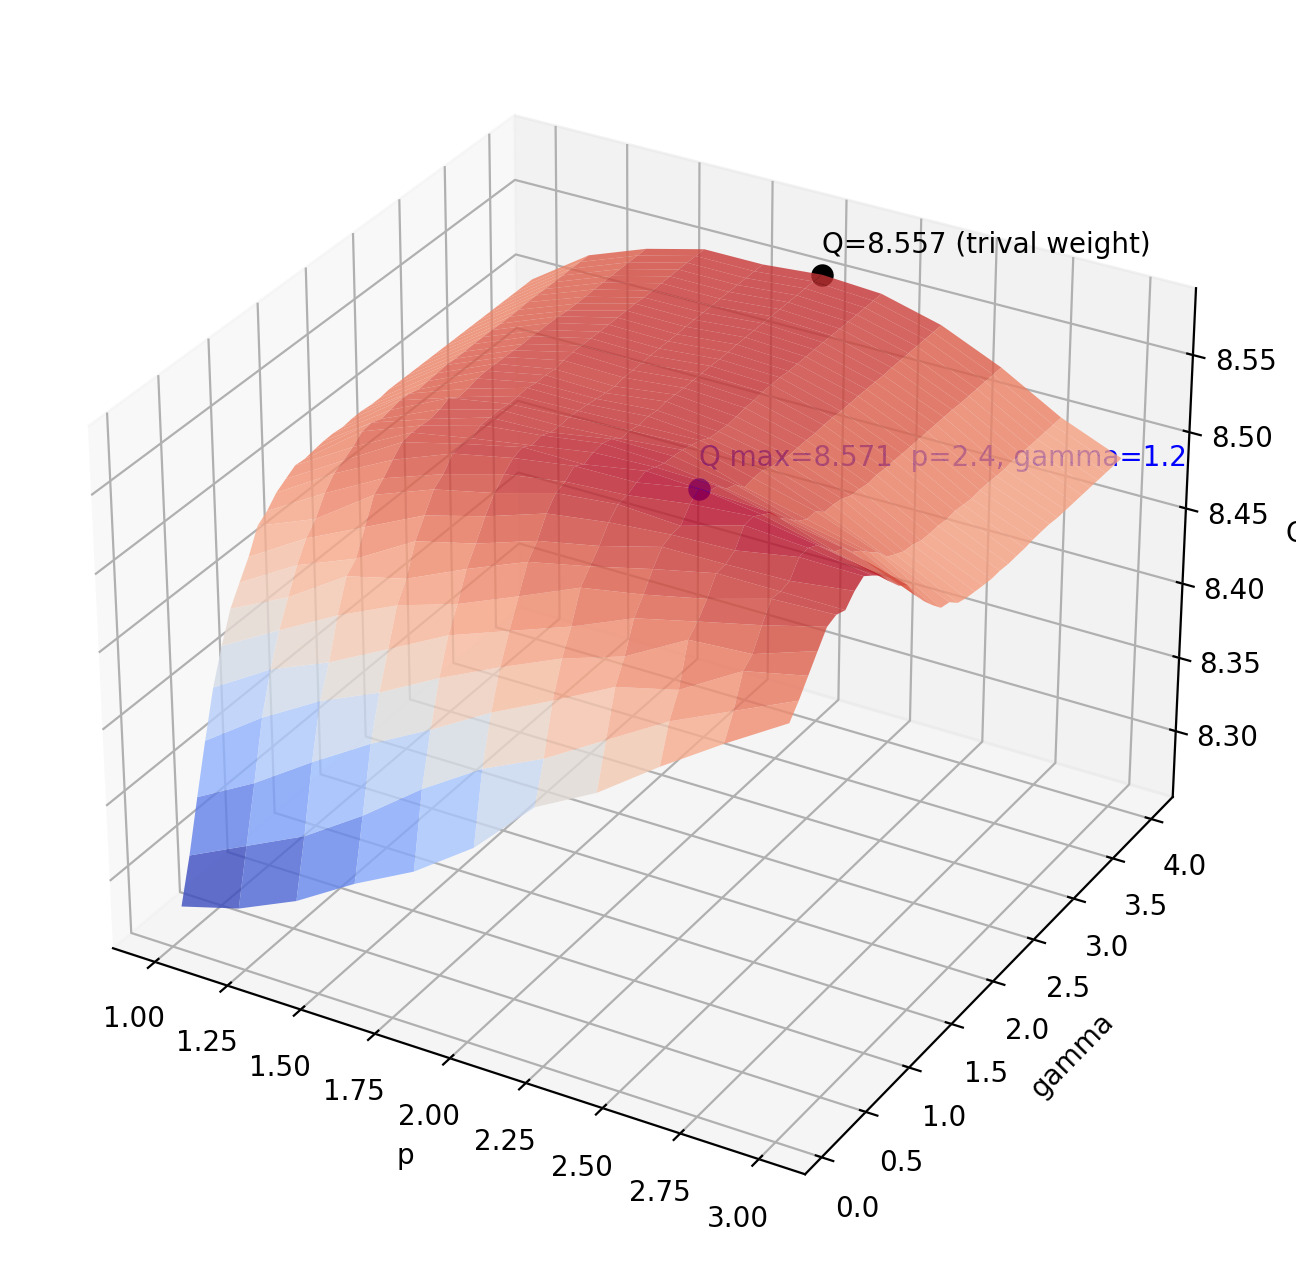

In [66]:
# 2d plot, X axis is p, Y axis is gamma, Z axis is Q
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

fig = plt.figure(figsize=(10,8), dpi=200)
ax = fig.add_subplot(111, projection='3d')

ps = np.linspace(1, 3, 11)
gammas = np.linspace(0.1, 4, 40)

X, Y = np.meshgrid(ps, gammas)
Z = np.array([np.mean(Q[f'p={p}, gamma={gamma}']) for p, gamma in zip(X.flatten(), Y.flatten())]).reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha=0.8)
ax.set_xlabel('p')
ax.set_ylabel('gamma')
ax.set_zlabel('Q')

# 标记点的坐标
p_mark =  2.0
gamma_mark = 4.0
# 假设已知 p=2 和 gamma=2 时的 Q 值
Q_mark = np.mean(Q[f'p={p_mark}, gamma={gamma_mark}'])

# 在曲面上标记点
ax.scatter(p_mark, gamma_mark, Q_mark, color='black', s=50)  # s 是点的大小
ax.text(p_mark, gamma_mark, Q_mark + 0.01, f'Q={Q_mark:.3f} (trival weight)', ha='left', va='bottom')

# max Q
gamma_max, p_max = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
Q_max = np.max(Z)
ax.scatter(ps[p_max], gammas[gamma_max], Q_max, color='b', s=50)  # s 是点的大小
ax.text(ps[p_max], gammas[gamma_max], Q_max+0.01, f'Q max={Q_max:.3f}  p={ps[p_max]:.1f}, gamma={gammas[gamma_max]:.1f}', ha='left', va='bottom', color='b')